In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
from make_roi_based_brain_map import roi_based_to_brain_map, show_roi_order, reorder_to_roi_order, create_animated_roi_brain_map
%matplotlib inline

In [3]:
result_files = glob('/external/rprshnas01/netdata_kcni/dflab/team/ma/ukb/imaging/svm_results_allrois_bilateral/emotion_binary/*.csv')
print(len(result_files))

KeyboardInterrupt: 

In [ ]:
aggregated_results  = pd.DataFrame()
for file in result_files:
    try:
        data_df = pd.read_csv(file, index_col='cv_fold')
        result_mean = data_df.mean()
        result_mean['ID'] = os.path.basename(file)[:-4]
        aggregated_results = aggregated_results.append(result_mean, ignore_index=True)
    except:
        print(file)
#     print(data_df.mean())
#     print(os.path.basename(file)[:-4])
    
    

/external/rprshnas01/netdata_kcni/dflab/team/ma/ukb/imaging/svm_results_allrois_bilateral/emotion_binary/5144730.csv
/external/rprshnas01/netdata_kcni/dflab/team/ma/ukb/imaging/svm_results_allrois_bilateral/emotion_binary/4441333.csv


In [ ]:
aggregated_results.info()

In [ ]:
print(aggregated_results.shape)
aggregated_results.isna().sum()

In [470]:
print(aggregated_results.shape)

(31009, 181)


In [471]:
subjects_list = list(aggregated_results.dropna()['ID'])
len(subjects_list)

31009

In [2]:
with open('valid_subjects_fmri_220726.txt', 'r') as f:
    subj_list = f.readlines()
subj_list = [int(s.strip()) for s in subj_list]
len(subj_list)

30945

In [ ]:
aggregated_results.dropna(inplace=True)
aggregated_results.info()

In [ ]:
aggregated_results.to_csv('svm_results_face_shape_hcp180_220726.csv', index=False)

In [3]:
aggregated_results = pd.read_csv('svm_results_face_shape_hcp180_220726.csv', index_col='ID')
aggregated_results.index.rename('eid', inplace=True)
aggregated_results = aggregated_results.loc[subj_list, :]
# aggregated_results = (aggregated_results - aggregated_results.mean()) / aggregated_results.std()

aggregated_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30945 entries, 1676025 to 5386080
Columns: 180 entries, roi_hcp180_10d_ROI to roi_hcp180_v23ab_ROI
dtypes: float64(180)
memory usage: 42.7 MB


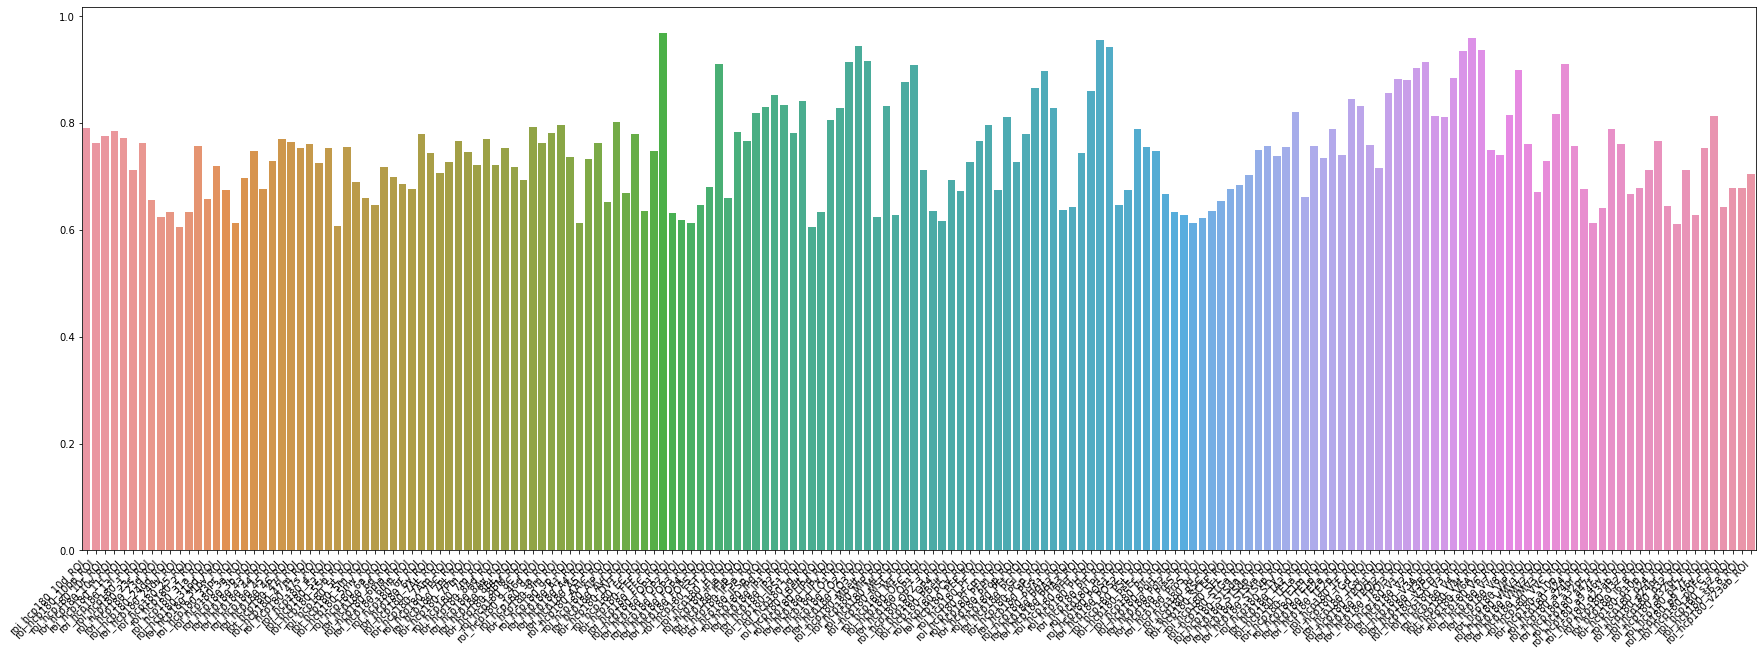

In [5]:
fig, ax = plt.subplots(figsize=(30,10))         # Sample figsize in inches

chart = sns.barplot(data=aggregated_results, ci=0.95, ax=ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.plot(np.arange(aggregated_results.shape[1]), 0.5*np.ones(aggregated_results.shape[1]), 'k--')
plt.show()

In [4]:
output_features = pd.read_csv('disorders_fmri.csv', index_col='eid')

In [5]:
output_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28367 entries, 1000177 to 6022251
Columns: 215 entries, F00 to S06
dtypes: bool(1), int64(214)
memory usage: 46.6 MB


In [6]:
output_features.shape

(28367, 215)

In [7]:
aggregated_results_bd = pd.merge(aggregated_results, output_features, how='left', left_index=True, right_index=True)


In [10]:
aggregated_results.reset_index(inplace=True)
# aggregated_results.drop(columns=['index'], inplace=True)
# aggregated_results.drop(columns=['level_0'], inplace=True)
aggregated_results_long = aggregated_results.melt(id_vars=["eid"], 
        var_name="roi", 
        value_name="accuracy")
aggregated_results_long.set_index('eid', inplace=True)
aggregated_results.set_index('eid', inplace=True)

In [11]:
aggregated_results_bd_long = pd.merge(aggregated_results_long, output_features, how='left', left_index=True, right_index=True)

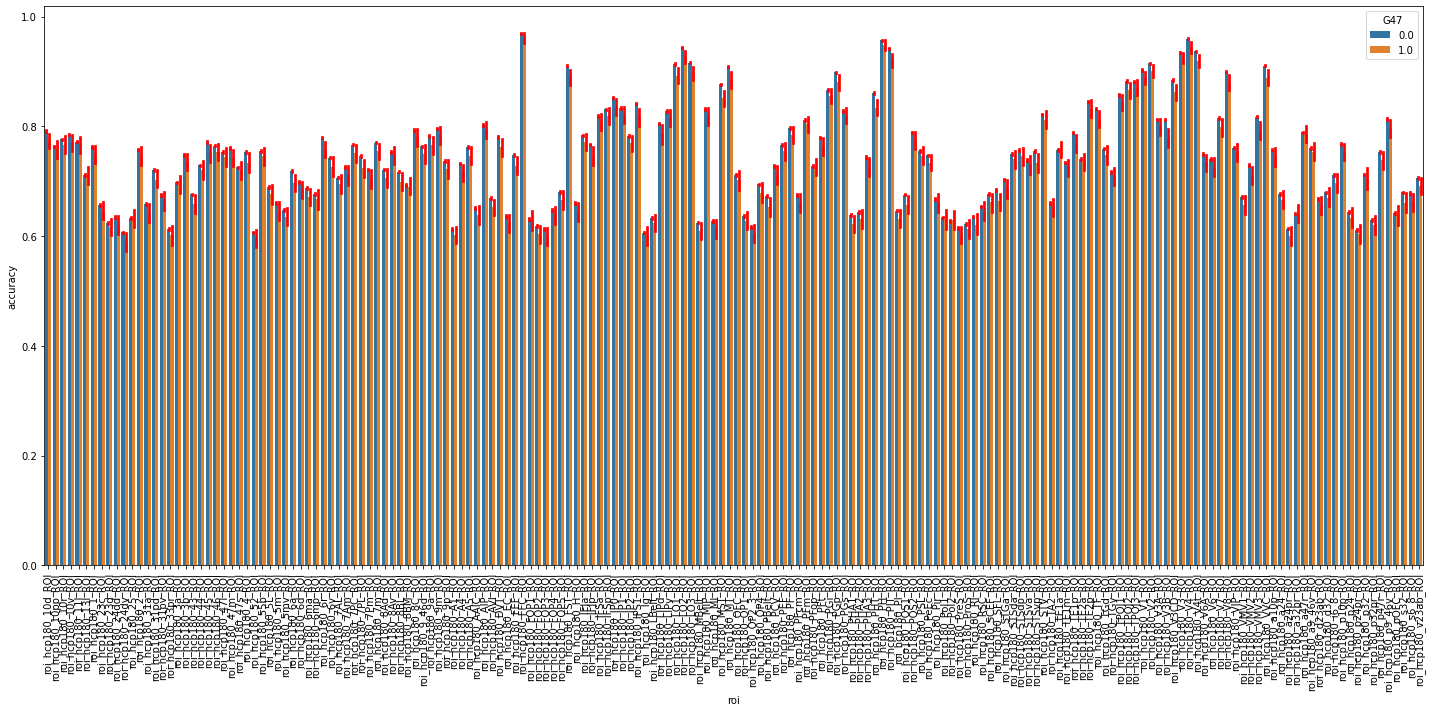

In [12]:
# sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches

chart = sns.barplot(x='roi', y='accuracy', 
                    data=aggregated_results_bd_long, 
                    ci=99, hue='G47', ax=ax,
                    errcolor='r')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='center')
# plt.plot(np.arange(3) - 0.5, 0.5*np.ones(3), 'r--')
# plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.show()


In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection

In [9]:
covariates_anatomy_df = pd.read_csv('covariates_task_230123.csv', index_col='eid')
covariates_anatomy_df['sex'] = covariates_anatomy_df['sex'].astype("category")
covariates_anatomy_df['site'] = covariates_anatomy_df['site'].astype("category")
covariates_anatomy_df['ethnicity'] = covariates_anatomy_df['ethnicity'].astype("category")
covariates_anatomy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52343 entries, 1000168 to 6024843
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 52343 non-null  float64 
 1   sex                 52343 non-null  category
 2   ses                 52343 non-null  float64 
 3   education           52343 non-null  float64 
 4   ethnicity           52198 non-null  category
 5   actigraphy_time     22321 non-null  float64 
 6   site                52339 non-null  category
 7   head_motion         52343 non-null  float64 
 8   accuracy_mean       36245 non-null  float64 
 9   response_time_mean  36245 non-null  float64 
 10  response_time_std   36245 non-null  float64 
dtypes: category(3), float64(8)
memory usage: 3.7 MB


In [10]:
ukb_tabular = pd.read_csv('/external/rprshnas01/kcni/mabdelhack/ml_tester/data/ukbiobank_sleep_variables_20220526_0910/data.csv', index_col='eid')
ukb_tabular.loc[ukb_tabular['Frequency of depressed mood in last 2 weeks']==0.0, 'Frequency of depressed mood in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Frequency of depressed mood in last 2 weeks']==1.0, 'Frequency of depressed mood in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Frequency of unenthusiasm / disinterest in last 2 weeks']==0.0, 'Frequency of unenthusiasm / disinterest in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Frequency of unenthusiasm / disinterest in last 2 weeks']==1.0, 'Frequency of unenthusiasm / disinterest in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Daytime dozing / sleeping (narcolepsy)']==0.0, 'Daytime dozing / sleeping (narcolepsy)'] = np.nan
ukb_tabular.loc[ukb_tabular['Daytime dozing / sleeping (narcolepsy)']==1.0, 'Daytime dozing / sleeping (narcolepsy)'] = np.nan
ukb_tabular.loc[ukb_tabular['Sleeplessness / insomnia']==0.0, 'Sleeplessness / insomnia'] = np.nan
ukb_tabular.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41169 entries, 1000177 to 6024843
Data columns (total 68 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Year of birth                                                          41169 non-null  float64
 1   Sex                                                                    41169 non-null  object 
 2   Summed MET minutes per week for all activity                           35061 non-null  float64
 3   Mean time to correctly identify matches                                38394 non-null  float64
 4   Maximum digits remembered correctly                                    28237 non-null  float64
 5   Fluid intelligence score                                               37908 non-null  float64
 6   Time to answer                                                         38612 n

In [11]:
tabular_tfmri = pd.merge(ukb_tabular, aggregated_results, how='inner', left_index=True, right_index=True)
tabular_tfmri.shape

(30862, 248)

In [12]:
tabular_tfmri = pd.merge(tabular_tfmri, covariates_anatomy_df, how='inner', left_index=True, right_index=True)
# tabular_tfmri.rename(columns={x:'IC_pair{}'.format(x) for x in range(210)}, inplace=True)
tabular_tfmri


,Year of birth,Sex,Summed MET minutes per week for all activity,Mean time to correctly identify matches,Maximum digits remembered correctly,Fluid intelligence score,Time to answer,Duration to complete alphanumeric path,Total errors traversing alphanumeric path,Number of puzzles correctly solved,...,sex,ses,education,ethnicity,actigraphy_time,site,head_motion,accuracy_mean_y,response_time_mean_y,response_time_std_y
eid,,,,,,,,,,,,,,,,,,,,,
1000177,44.0,Male,1182.5,483.0,NaN,7.0,355.0,NaN,NaN,NaN,...,Male,-2.142610,18.00000,White,NaN,Cheadle (imaging),0.111378,1.000000,907.333333,216.277887
1000184,55.0,Female,1053.0,612.0,6.0,5.0,1688.0,591.0,0.0,9.0,...,Female,-4.606500,16.00000,White,NaN,Cheadle (imaging),0.153434,0.883333,970.000000,407.506390
1000412,52.0,Female,2106.0,702.0,8.0,3.0,2313.0,937.0,0.0,6.0,...,Female,-0.434521,16.61626,White,NaN,Reading (imaging),0.171447,0.950000,1108.400000,383.023175
1000486,57.0,Female,3417.0,593.0,6.0,10.0,1666.0,483.0,2.0,8.0,...,Female,-1.283720,16.00000,White,NaN,Newcastle (imaging),0.160320,0.466667,379.600000,435.492093
1000725,61.0,Female,1184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Female,-0.363590,16.61626,White,NaN,Cheadle (imaging),0.082948,1.000000,824.150000,275.545673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021255,48.0,Female,165.0,577.0,7.0,7.0,1651.0,430.0,1.0,10.0,...,Female,-4.023030,16.61626,White,3.676934,Newcastle (imaging),0.141902,0.966667,1042.483333,263.898189
6021415,62.0,Male,1794.0,655.0,NaN,5.0,432.0,NaN,NaN,NaN,...,Male,-4.469670,16.00000,White,NaN,Cheadle (imaging),0.171456,0.883333,937.866667,363.019235
6022057,61.0,Female,4230.0,620.0,NaN,7.0,412.0,NaN,NaN,NaN,...,Female,-3.807310,16.61626,White,NaN,Cheadle (imaging),0.127120,0.900000,1093.233333,456.031829


In [13]:
# normal model

tabular_tfmri['age'] = (tabular_tfmri['age'] - tabular_tfmri['age'].mean() ) / tabular_tfmri['age'].std()
tabular_tfmri['actigraphy_time'] = (tabular_tfmri['actigraphy_time'] - tabular_tfmri['actigraphy_time'].mean() ) / tabular_tfmri['actigraphy_time'].std()
tabular_tfmri['head_motion'] = (tabular_tfmri['head_motion'] - tabular_tfmri['head_motion'].mean() ) / tabular_tfmri['head_motion'].std()
tabular_tfmri['response_time_mean_y'] = (tabular_tfmri['response_time_mean_y'] - tabular_tfmri['response_time_mean_y'].mean() ) / tabular_tfmri['response_time_mean_y'].std()
tabular_tfmri['accuracy_mean_y'] = (tabular_tfmri['accuracy_mean_y'] - tabular_tfmri['accuracy_mean_y'].mean() ) / tabular_tfmri['accuracy_mean_y'].std()
tabular_tfmri['response_time_std_y'] = (tabular_tfmri['response_time_std_y'] - tabular_tfmri['response_time_std_y'].mean() ) / tabular_tfmri['response_time_std_y'].std()
tabular_tfmri['ses'] = (tabular_tfmri['ses'] - tabular_tfmri['ses'].mean() ) / tabular_tfmri['ses'].std()
tabular_tfmri['education'] = (tabular_tfmri['education'] - tabular_tfmri['education'].mean() ) / tabular_tfmri['education'].std()

roi_list = list(aggregated_results.columns.str.replace('.', '_'))
tabular_tfmri.columns = tabular_tfmri.columns.str.replace('.', '_')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace(' ', '_')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace('/', '_')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace('(', '')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace(')', '')


In [14]:
def make_ols_maps(data, indep_variable, output_list, accuracy_data, save=True):
    data_copy = data.copy(deep=True)
    data_copy[independent_var] = (data_copy[indep_variable] - data[indep_variable].mean() ) / data_copy[indep_variable].std()


    pt_values = dict()

    for idx, roi in enumerate(output_list):
        phenotype_name = roi
        if indep_variable == 'duration_of_longest_sleep_bout':
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + ses + education + C(ethnicity) + actigraphy_time + head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                               data=data_copy)
        else:
        
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + ses + education + C(ethnicity) + education+ head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                                   data=data_copy)
        lr_results = lr_model.fit()
#         print(lr_results.params)
#         print(lr_results.conf_int(0.05))
#         break
        for idx2 , var in enumerate(lr_results.pvalues.keys()):
            if var not in pt_values.keys():
                pt_values[var] = pd.DataFrame(index=output_list, columns=['p', 't', 'beta', 'conf_interval_lower', 'conf_interval_higher'])
            pt_values[var].loc[roi, 'p'] = lr_results.pvalues[var]
            pt_values[var].loc[roi, 't'] = lr_results.tvalues[var]
            pt_values[var].loc[roi, 'beta'] = lr_results.params[var]
            pt_values[var].loc[roi, 'conf_interval_lower'] = lr_results.conf_int(0.05).loc[var, 0]
            pt_values[var].loc[roi, 'conf_interval_higher'] = lr_results.conf_int(0.05).loc[var, 1]
    for idx, variable in enumerate(pt_values.keys()):
        pt_values[variable]['p_fdr'] = fdrcorrection(pt_values[variable]['p'], alpha=0.05, method='i')[1]
        pt_values[variable]['t_sig'] = pt_values[variable]['t']
        pt_values[variable]['t_bonf'] = pt_values[variable]['t']
        pt_values[variable]['beta_sig'] = pt_values[variable]['beta']
        pt_values[variable]['beta_bonf'] = pt_values[variable]['beta']
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 't_sig'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 'beta_sig'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p'] >=(0.05)/(180*4), 't_bonf'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p'] >=(0.05)/(180*4), 'beta_bonf'] = np.nan
        pt_values[variable]['accuracy_mean'] = accuracy_data.mean()
        pt_values[variable]['t_normalized_by_acc'] = pt_values[variable]['t'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['t_sig_normalized_by_acc'] = pt_values[variable]['t_sig'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['t_bonf_normalized_by_acc'] = pt_values[variable]['t_bonf'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_normalized_by_acc'] = pt_values[variable]['beta'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_sig_normalized_by_acc'] = pt_values[variable]['beta_sig'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_bonf_normalized_by_acc'] = pt_values[variable]['beta_bonf'] / (1 - pt_values[variable]['accuracy_mean'])
        
        pt_values[variable].to_csv('results/task/stats/{}_{}_stats.csv'.format(independent_var, variable))

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_sig_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_beta_sig_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_beta_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_bonf_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_beta_bonf_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_beta'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_beta_sig'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_beta_bonf'.format(independent_var, variable), parcellation='hcp180')
        

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t_sig_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t_bonf_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t_sig'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t_bonf'.format(independent_var, variable), parcellation='hcp180')

    
    return pt_values

In [54]:
def make_ols_maps_sex(data, indep_variable, output_list, accuracy_data):
#     independent_var = 'duration_of_longest_sleep_bout'
    data_copy = data.copy(deep=True)
    data_copy[independent_var] = (data_copy[indep_variable] - data_copy[indep_variable].mean() ) / data_copy[indep_variable].std()


    pt_values_strat = dict()
    for sex in ['Male', 'Female']:
        pt_values = dict()
        data_strat = data_copy.loc[data_copy['sex'] == sex]
        for idx, roi in enumerate(output_list):
            phenotype_name = roi
            if indep_variable == 'duration_of_longest_sleep_bout':
                lr_model = smf.ols('{} ~ {} + C(site) + age + actigraphy_time + head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                                   data=data_copy)
            else:
        
                lr_model = smf.ols('{} ~ {} + C(site) + age + head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                                       data=data_copy)
            lr_results = lr_model.fit()
        #     print(lr_results.summary())
        #     break
            for idx2 , var in enumerate(lr_results.pvalues.keys()):
                if var not in pt_values.keys():
                    pt_values[var] = pd.DataFrame(index=output_list, columns=['p', 't'])
                pt_values[var].loc[roi, 'p'] = lr_results.pvalues[var]
                pt_values[var].loc[roi, 't'] = lr_results.tvalues[var]
        for idx, variable in enumerate(pt_values.keys()):
            pt_values[variable]['p_fdr'] = fdrcorrection(pt_values[variable]['p'], alpha=0.05, method='i')[1]
            pt_values[variable]['t_sig'] = pt_values[variable]['t']
            pt_values[variable]['t_bonf'] = pt_values[variable]['t']
            pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 't_sig'] = np.nan
            pt_values[variable].loc[pt_values[variable]['p'] >=(0.05)/(180*4), 't_bonf'] = np.nan
            pt_values[variable]['accuracy_mean'] = accuracy_data.mean()
            pt_values[variable]['t_normalized_by_acc'] = pt_values[variable]['t'] / (1 - pt_values[variable]['accuracy_mean'])
            pt_values[variable]['t_sig_normalized_by_acc'] = pt_values[variable]['t_sig'] / (1 - pt_values[variable]['accuracy_mean'])
            pt_values[variable]['t_bonf_normalized_by_acc'] = pt_values[variable]['t_bonf'] / (1 - pt_values[variable]['accuracy_mean'])
            pt_values[variable].to_csv('results/task/stats/{}_{}_stats_sexstratified_{}.csv'.format(independent_var, variable, sex))
            

            lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_svm_hcp180_t_sig_normalized_by_acc_{}'.format(variable, sex), parcellation='hcp180')

            lh_correlations = reorder_to_roi_order(pt_values[variable]['t_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_svm_hcp180_t_normalized_by_acc_{}'.format(variable, sex), parcellation='hcp180')
            
            lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t_bonf_normalized_by_acc_{}'.format(independent_var, variable, sex), parcellation='hcp180')

            lh_correlations = reorder_to_roi_order(pt_values[variable]['t'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_svm_hcp180_t_{}'.format(variable, sex), parcellation='hcp180')

            lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_svm_hcp180_t_sig_{}'.format(variable, sex), parcellation='hcp180')
            
            lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '{}_{}_svm_hcp180_t_bonf_{}'.format(independent_var, variable, sex), parcellation='hcp180')

        pt_values_strat[sex] = pt_values
    return pt_values_strat

In [21]:
independent_var = 'duration_of_longest_sleep_bout'
longest_sleep_bout_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results)
# longest_sleep_bout_stats_strat = make_ols_maps_sex(tabular_tfmri, independent_var, roi_list, aggregated_results)


In [55]:
independent_var = 'duration_of_longest_sleep_bout'
# longest_sleep_bout_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results, save=False)
longest_sleep_bout_stats_strat = make_ols_maps_sex(tabular_tfmri, independent_var, roi_list, aggregated_results)

In [102]:
longest_sleep_bout_stats[independent_var].sort_values(by='beta_sig_normalized_by_acc', ascending=False)

,p,t,beta,conf_interval_lower,conf_interval_higher,p_fdr,t_sig,t_bonf,beta_sig,beta_bonf,accuracy_mean,t_normalized_by_acc,t_sig_normalized_by_acc,t_bonf_normalized_by_acc,beta_normalized_by_acc,beta_sig_normalized_by_acc,beta_bonf_normalized_by_acc
roi_hcp180_LO2_ROI,1.39405e-05,4.34646,0.00223955,0.00122957,0.00324954,0.000836428,4.34646,4.34646,0.00223955,0.00223955,0.943396,76.7873,76.7873,76.7873,0.0395654,0.0395654,0.0395654
roi_hcp180_FST_ROI,0.00012441,3.83843,0.00259638,0.0012705,0.00392225,0.00240161,3.83843,NaN,0.00259638,NaN,0.910180,42.7348,42.7348,NaN,0.0289065,0.0289065,NaN
roi_hcp180_V8_ROI,9.14327e-05,3.9135,0.00271649,0.00135589,0.0040771,0.00235113,3.9135,NaN,0.00271649,NaN,0.899149,38.8046,38.8046,NaN,0.0269356,0.0269356,NaN
roi_hcp180_MIP_ROI,7.96694e-06,4.46787,0.0035633,0.00200001,0.0051266,0.000717024,4.46787,4.46787,0.0035633,0.0035633,0.831164,26.4628,26.4628,26.4628,0.0211051,0.0211051,0.0211051
roi_hcp180_IP1_ROI,0.000133423,3.8212,0.00304059,0.00148087,0.00460032,0.00240161,3.8212,NaN,0.00304059,NaN,0.833158,22.9031,22.9031,NaN,0.0182244,0.0182244,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
roi_hcp180_p9_46v_ROI,0.0128195,2.48909,0.00212202,0.000450938,0.00379309,0.0384586,NaN,NaN,NaN,NaN,0.812767,13.2941,NaN,NaN,0.0113335,NaN,NaN
roi_hcp180_pOFC_ROI,0.180291,1.33993,0.00127309,-0.000589275,0.00313545,0.231803,NaN,NaN,NaN,NaN,0.642641,3.74953,NaN,NaN,0.00356248,NaN,NaN
roi_hcp180_s32_ROI,0.129118,1.51768,0.00142433,-0.000415246,0.0032639,0.181573,NaN,NaN,NaN,NaN,0.679035,4.72851,NaN,NaN,0.00443764,NaN,NaN
roi_hcp180_s6_8_ROI,0.0500911,1.95937,0.00187599,-7.45487e-07,0.00375273,0.0874413,NaN,NaN,NaN,NaN,0.677929,6.08365,NaN,NaN,0.00582478,NaN,NaN


In [22]:
longest_sleep_bout_stats[independent_var].dropna(subset=['beta_sig'])

,p,t,beta,conf_interval_lower,conf_interval_higher,p_fdr,t_sig,t_bonf,beta_sig,beta_bonf,accuracy_mean,t_normalized_by_acc,t_sig_normalized_by_acc,t_bonf_normalized_by_acc,beta_normalized_by_acc,beta_sig_normalized_by_acc,beta_bonf_normalized_by_acc
roi_hcp180_43_ROI,0.000657455,3.40756,0.00322379,0.00136936,0.00507823,0.00845299,3.40756,NaN,0.00322379,NaN,0.675598,10.5041,10.5041,NaN,0.00993765,0.00993765,NaN
roi_hcp180_5L_ROI,0.00164566,3.14835,0.00304752,0.00115015,0.0049449,0.0123425,3.14835,NaN,0.00304752,NaN,0.688745,10.115,10.115,NaN,0.00979109,0.00979109,NaN
roi_hcp180_5m_ROI,0.00109046,3.26682,0.00316092,0.00126431,0.00505752,0.0115592,3.26682,NaN,0.00316092,NaN,0.659922,9.60609,9.60609,NaN,0.00929468,0.00929468,NaN
roi_hcp180_6a_ROI,0.00117159,3.24643,0.00310431,0.00122997,0.00497864,0.0115592,3.24643,NaN,0.00310431,NaN,0.717499,11.4918,11.4918,NaN,0.0109887,0.0109887,NaN
roi_hcp180_7Am_ROI,4.04922e-05,4.10607,0.00375221,0.00196099,0.00554343,0.00145772,4.10607,4.10607,0.00375221,0.00375221,0.726202,14.9967,14.9967,14.9967,0.0137043,0.0137043,0.0137043
roi_hcp180_EC_ROI,0.00137425,3.2007,0.00305071,0.00118242,0.004919,0.0115592,3.2007,NaN,0.00305071,NaN,0.635600,8.78347,8.78347,NaN,0.00837187,0.00837187,NaN
roi_hcp180_FST_ROI,8.11094e-05,3.94236,0.00267457,0.00134477,0.00400436,0.00182035,3.94236,NaN,0.00267457,NaN,0.910173,43.8883,43.8883,NaN,0.0297746,0.0297746,NaN
roi_hcp180_IP1_ROI,0.00010113,3.88907,0.00310492,0.00154,0.00466984,0.00182035,3.88907,NaN,0.00310492,NaN,0.833159,23.31,23.31,NaN,0.01861,0.01861,NaN
roi_hcp180_LIPd_ROI,0.00141279,3.19272,0.00276239,0.00106644,0.00445834,0.0115592,3.19272,NaN,0.00276239,NaN,0.805042,16.3764,16.3764,NaN,0.0141691,0.0141691,NaN
roi_hcp180_LO2_ROI,6.91467e-06,4.49814,0.00232117,0.00130968,0.00333267,0.000613497,4.49814,4.49814,0.00232117,0.00232117,0.943400,79.4719,79.4719,79.4719,0.0410098,0.0410098,0.0410098


In [130]:
print(longest_sleep_bout_stats[independent_var].index[70])
roi_names = [x[11:-4] for x in longest_sleep_bout_stats[independent_var].index]
print(roi_names[70])

roi_hcp180_IFJa_ROI
IFJa


In [132]:
longest_sleep_bout_stats[independent_var].index = roi_names
longest_sleep_bout_stats[independent_var].head()

,p,t,beta,conf_interval_lower,conf_interval_higher,p_fdr,t_sig,t_bonf,beta_sig,beta_bonf,accuracy_mean,t_normalized_by_acc,t_sig_normalized_by_acc,t_bonf_normalized_by_acc,beta_normalized_by_acc,beta_sig_normalized_by_acc,beta_bonf_normalized_by_acc
10d,0.0932248,1.67875,0.00141296,-0.000236843,0.00306276,0.14552,NaN,NaN,NaN,NaN,0.790775,8.02364,NaN,NaN,0.00675327,NaN,NaN
10pp,0.395369,0.84995,0.000749513,-0.000979007,0.00247803,0.439298,NaN,NaN,NaN,NaN,0.763475,3.59349,NaN,NaN,0.00316885,NaN,NaN
10r,0.432862,0.784328,0.000682844,-0.00102368,0.00238937,0.469369,NaN,NaN,NaN,NaN,0.776096,3.50296,NaN,NaN,0.00304971,NaN,NaN
10v,0.0650586,1.84501,0.0015615,-9.7443e-05,0.00322044,0.107436,NaN,NaN,NaN,NaN,0.784646,8.56735,NaN,NaN,0.00725086,NaN,NaN
11l,0.0042621,2.85859,0.00250916,0.000788617,0.0042297,0.0191795,NaN,NaN,NaN,NaN,0.772191,12.5482,NaN,NaN,0.0110143,NaN,NaN


<ErrorbarContainer object of 3 artists>

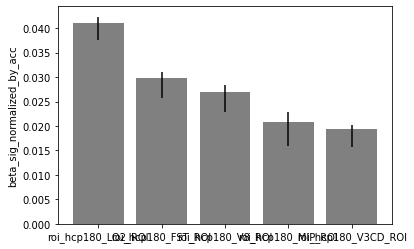

In [23]:
max_rois = 5
fig, axes = plt.subplots(1,1)
sns.barplot(x=longest_sleep_bout_stats[independent_var].sort_values(by='beta_sig_normalized_by_acc', ascending=False).index[:max_rois], 
            y=longest_sleep_bout_stats[independent_var].sort_values(by='beta_sig_normalized_by_acc', ascending=False)['beta_sig_normalized_by_acc'][:max_rois],
           facecolor='0.5')
plt.errorbar(x=longest_sleep_bout_stats[independent_var].index[:max_rois], 
             y=longest_sleep_bout_stats[independent_var].sort_values(by='beta_sig_normalized_by_acc', ascending=False)['beta_sig_normalized_by_acc'][:max_rois],
             yerr=longest_sleep_bout_stats[independent_var].sort_values(by='beta_sig_normalized_by_acc', ascending=False)[['conf_interval_higher', 'conf_interval_lower']][:max_rois].values.T,
            fmt='none', c='black', capsize=0)

In [138]:
fig.savefig('./results/task/stats/{}_svm_top{}_rois_221024.pdf'.format(independent_var, max_rois), facecolor='white', dpi=600) 

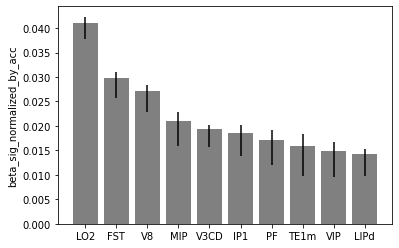

In [39]:
independent_var = 'duration_of_longest_sleep_bout'
plot_betas_top_rois(longest_sleep_bout_stats[independent_var], 'accel_sleep', top_x=10, save=True)

In [48]:
def plot_betas_top_rois(stats_df, var_name, top_x=5, save=True):
    fig, axes = plt.subplots(1,1)
    roi_names = [x[11:-4] for x in stats_df.index]
    stats_df.index = roi_names
    stats_df = -stats_df
    sns.barplot(x=stats_df.sort_values(by='beta_sig_normalized_by_acc', ascending=False).index[:top_x], 
                y=stats_df.sort_values(by='beta_sig_normalized_by_acc', ascending=False)['beta_sig_normalized_by_acc'][:top_x],
               facecolor='0.5')
    plt.errorbar(x=stats_df.index[:top_x], 
                 y=stats_df.sort_values(by='beta_sig_normalized_by_acc', ascending=False)['beta_sig_normalized_by_acc'][:top_x],
                 yerr=stats_df.sort_values(by='beta_sig_normalized_by_acc', ascending=False)[['conf_interval_higher', 'conf_interval_lower']][:top_x].values.T,
                fmt='none', c='black', capsize=0)
    if save:
        fig.savefig('./results/task/stats/{}_svm_top{}_rois_230123.pdf'.format(var_name, top_x), facecolor='white', dpi=600) 

In [565]:
for column in tabular_tfmri.columns:
    print(column)

Year_of_birth
Sex
Summed_MET_minutes_per_week_for_all_activity
Mean_time_to_correctly_identify_matches
Maximum_digits_remembered_correctly
Fluid_intelligence_score
Time_to_answer
Duration_to_complete_alphanumeric_path
Total_errors_traversing_alphanumeric_path
Number_of_puzzles_correctly_solved
Number_of_puzzles_viewed
Number_of_puzzles_correct
Number_of_puzzles_attempted
Number_of_symbol_digit_matches_made_correctly
Number_of_symbol_digit_matches_attempted
Number_of_word_pairs_correctly_associated
Mood_swings
Miserableness
Irritability
Sensitivity___hurt_feelings
Fed-up_feelings
Nervous_feelings
Worrier___anxious_feelings
Tense___'highly_strung'
Worry_too_long_after_embarrassment
Suffer_from_'nerves'
Loneliness,_isolation
Guilty_feelings
Risk_taking
Happiness
Frequency_of_depressed_mood_in_last_2_weeks
Frequency_of_unenthusiasm___disinterest_in_last_2_weeks
Frequency_of_tenseness___restlessness_in_last_2_weeks
Frequency_of_tiredness___lethargy_in_last_2_weeks
Length_of_longest_manic_ir

In [26]:
independent_var = 'Number_of_symbol_digit_matches_made_correctly'
cognitive_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results)
# make_ols_maps_sex(tabular_tfmri, independent_var, roi_list, aggregated_results)

In [27]:
cognitive_stats[independent_var].dropna(subset=['beta_sig'])

,p,t,beta,conf_interval_lower,conf_interval_higher,p_fdr,t_sig,t_bonf,beta_sig,beta_bonf,accuracy_mean,t_normalized_by_acc,t_sig_normalized_by_acc,t_bonf_normalized_by_acc,beta_normalized_by_acc,beta_sig_normalized_by_acc,beta_bonf_normalized_by_acc
roi_hcp180_45_ROI,0.00149847,3.17543,0.00251651,0.000963154,0.00406986,0.00870078,3.17543,NaN,0.00251651,NaN,0.770775,13.8529,13.8529,NaN,0.0109783,0.0109783,NaN
roi_hcp180_46_ROI,0.00227961,3.05156,0.00242169,0.000866187,0.0039772,0.0120685,3.05156,NaN,0.00242169,NaN,0.764491,12.9573,12.9573,NaN,0.0102828,0.0102828,NaN
roi_hcp180_55b_ROI,1.43449e-07,5.26272,0.00422033,0.00264848,0.00579219,8.60693e-06,5.26272,5.26272,0.00422033,0.00422033,0.754643,21.4492,21.4492,21.4492,0.0172008,0.0172008,0.0172008
roi_hcp180_6a_ROI,0.00179706,3.1223,0.00264193,0.000983408,0.00430046,0.0101085,3.1223,NaN,0.00264193,NaN,0.717499,11.0524,11.0524,NaN,0.00935195,0.00935195,NaN
roi_hcp180_8Ad_ROI,0.00070888,3.38667,0.00283147,0.00119271,0.00447023,0.00472587,3.38667,NaN,0.00283147,NaN,0.720985,12.1379,12.1379,NaN,0.0101481,0.0101481,NaN
roi_hcp180_8Av_ROI,0.000405017,3.53741,0.00279873,0.00124795,0.00434951,0.0031697,3.53741,NaN,0.00279873,NaN,0.752823,14.3112,14.3112,NaN,0.0113228,0.0113228,NaN
roi_hcp180_8BL_ROI,0.00199791,3.09096,0.00256157,0.000937189,0.00418594,0.0108977,3.09096,NaN,0.00256157,NaN,0.717087,10.9255,10.9255,NaN,0.00905425,0.00905425,NaN
roi_hcp180_9_46d_ROI,7.90046e-05,3.94824,0.00320782,0.00161531,0.00480032,0.000748465,3.94824,NaN,0.00320782,NaN,0.763295,16.68,16.68,NaN,0.0135519,0.0135519,NaN
roi_hcp180_AIP_ROI,4.84641e-05,4.06383,0.00307324,0.00159094,0.00455554,0.000545222,4.06383,4.06383,0.00307324,0.00307324,0.801918,20.5159,20.5159,20.5159,0.015515,0.015515,0.015515
roi_hcp180_FEF_ROI,3.38304e-12,6.96526,0.00564128,0.00405377,0.00722878,6.08947e-10,6.96526,6.96526,0.00564128,0.00564128,0.747989,27.6387,27.6387,27.6387,0.0223851,0.0223851,0.0223851


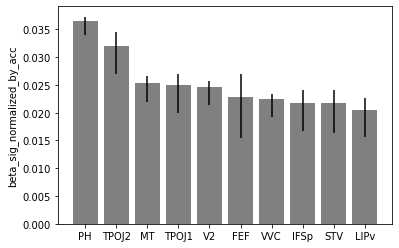

In [30]:
plot_betas_top_rois(cognitive_stats[independent_var], 'cognitive', top_x=10, save=True)

In [31]:
independent_var = 'Sleeplessness___insomnia'
insomnia_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results)
insomnia_stats[independent_var].dropna(subset=['beta_sig'])
# make_ols_maps_sex(tabular_tfmri, independent_var, roi_list, aggregated_results)

,p,t,beta,conf_interval_lower,conf_interval_higher,p_fdr,t_sig,t_bonf,beta_sig,beta_bonf,accuracy_mean,t_normalized_by_acc,t_sig_normalized_by_acc,t_bonf_normalized_by_acc,beta_normalized_by_acc,beta_sig_normalized_by_acc,beta_bonf_normalized_by_acc
roi_hcp180_i6_8_ROI,2.21208e-05,-4.24299,-0.00250083,-0.00365608,-0.00134557,0.00398175,-4.24299,-4.24299,-0.00250083,-0.00250083,0.711526,-14.7084,-14.7084,-14.7084,-0.00866915,-0.00866915,-0.00866915


In [16]:
tabular_tfmri['phq2'] = tabular_tfmri['Frequency_of_depressed_mood_in_last_2_weeks'] + tabular_tfmri['Frequency_of_unenthusiasm___disinterest_in_last_2_weeks']


In [15]:
independent_var = 'phq2'
phq2_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results)
phq2_stats[independent_var].dropna(subset=['beta_sig'])
# make_ols_maps_sex(tabular_tfmri, independent_var, roi_list, aggregated_results)

KeyError: 'phq2'

In [46]:
phq2_stats.keys()

dict_keys(['Intercept', 'C(site)[T.Cheadle (imaging)]', 'C(site)[T.Newcastle (imaging)]', 'C(site)[T.Reading (imaging)]', 'C(sex)[T.Male]', 'C(ethnicity)[T.Black or Black British]', 'C(ethnicity)[T.Chinese]', 'C(ethnicity)[T.Mixed]', 'C(ethnicity)[T.Other ethnic group]', 'C(ethnicity)[T.White]', 'Daytime_dozing___sleeping_narcolepsy', 'age', 'age:C(sex)[T.Male]', 'ses', 'education', 'head_motion', 'response_time_mean_y', 'accuracy_mean_y', 'response_time_std_y'])

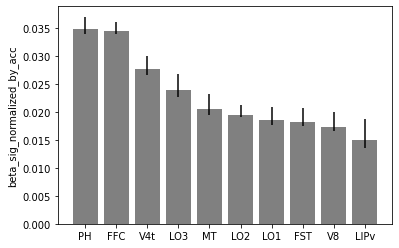

In [53]:
plot_betas_top_rois(phq2_stats['phq2'], 'phq2', top_x=10
                    , save=True)

In [36]:
independent_var = 'Daytime_dozing___sleeping_narcolepsy'
phq2_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results)
phq2_stats[independent_var].dropna(subset=['beta_sig'])

,p,t,beta,conf_interval_lower,conf_interval_higher,p_fdr,t_sig,t_bonf,beta_sig,beta_bonf,accuracy_mean,t_normalized_by_acc,t_sig_normalized_by_acc,t_bonf_normalized_by_acc,beta_normalized_by_acc,beta_sig_normalized_by_acc,beta_bonf_normalized_by_acc


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


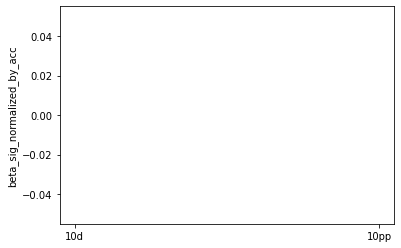

In [20]:
plot_betas_top_rois(phq2_stats['Daytime_dozing___sleeping_narcolepsy'], 'dozing', top_x=10
                    , save=True)

In [94]:
selected_columns = ['sex', 'site', 'age', 'actigraphy_time', 'head_motion', 
                    'response_time_mean_y', 'accuracy_mean_y', 'response_time_std_y',
                    'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 
                    'duration_of_longest_sleep_bout', 'Daytime_dozing___sleeping_narcolepsy', 'bedtime']
selected_columns.extend(list(aggregated_results.columns))
len(selected_columns)

194

In [38]:
t_fdr_independent = pd.DataFrame()
t_independent = pd.DataFrame()
for independent_var in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy', 'Number_of_symbol_digit_matches_made_correctly', 'phq2']:
    data_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results, save=False)
    t_fdr_independent[independent_var] = data_stats[independent_var]['beta_sig_normalized_by_acc']
    t_independent[independent_var] = data_stats[independent_var]['beta_normalized_by_acc']
t_independent['accuracy'] = data_stats[independent_var]['accuracy_mean']

In [95]:
tfmri_data_covariates = tabular_tfmri.loc[:, selected_columns]
tfmri_data_covariates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30862 entries, 1000177 to 6022251
Columns: 194 entries, sex to roi_hcp180_v23ab_ROI
dtypes: category(2), float64(192)
memory usage: 45.5 MB


In [96]:
tfmri_data_covariates.to_csv('tfmri_data_covariates_221205.csv', index=True)

In [30]:
t_fdr_independent_sig = t_fdr_independent[(~t_fdr_independent.isna()).sum(axis=1) > 1]
t_fdr_independent_sig.sort_values(by='Number_of_symbol_digit_matches_made_correctly', ascending=False)

,duration_of_longest_sleep_bout,Sleeplessness___insomnia,Daytime_dozing___sleeping_narcolepsy,Number_of_symbol_digit_matches_made_correctly,phq2
roi_hcp180_SCEF_ROI,NaN,NaN,NaN,0.00439966,-0.00276736
roi_hcp180_LIPv_ROI,NaN,NaN,NaN,0.003634,-0.00260008
roi_hcp180_i6_8_ROI,NaN,-0.0025062,NaN,0.00354641,-0.00217007
roi_hcp180_MIP_ROI,0.00365731,NaN,NaN,0.00354106,-0.00248094
roi_hcp180_LIPd_ROI,0.00275707,NaN,NaN,0.00336342,-0.00230274
roi_hcp180_IFJp_ROI,NaN,NaN,NaN,0.0033153,-0.0016883
roi_hcp180_AIP_ROI,NaN,NaN,NaN,0.00307324,-0.00178981
roi_hcp180_IP1_ROI,0.00311665,NaN,NaN,0.00282662,-0.00242865
roi_hcp180_6a_ROI,0.0030993,NaN,NaN,0.00264193,NaN
roi_hcp180_IP0_ROI,NaN,NaN,NaN,0.0025288,-0.00160582


In [174]:
t_fdr_independent_sig = t_fdr_independent_sig.loc[:, [
, 'phq2']]+

In [56]:
beta_overlap = (~t_fdr_independent.isna()[(~t_fdr_independent.isna()).sum(axis=1) > 1]).astype(int).astype(str).agg(''.join, axis=1).astype(int)
print(beta_overlap.index)
lh_correlations = reorder_to_roi_order(beta_overlap.to_frame(), 'lh', None, parcellation='hcp180')
roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'sig_overlaponly_pattern', parcellation='hcp180')

Index(['roi_hcp180_45_ROI', 'roi_hcp180_6a_ROI', 'roi_hcp180_7Am_ROI',
       'roi_hcp180_8C_ROI', 'roi_hcp180_AIP_ROI', 'roi_hcp180_EC_ROI',
       'roi_hcp180_FST_ROI', 'roi_hcp180_IFJa_ROI', 'roi_hcp180_IFJp_ROI',
       'roi_hcp180_IFSa_ROI', 'roi_hcp180_IP0_ROI', 'roi_hcp180_IP1_ROI',
       'roi_hcp180_LIPd_ROI', 'roi_hcp180_LIPv_ROI', 'roi_hcp180_LO2_ROI',
       'roi_hcp180_MIP_ROI', 'roi_hcp180_MST_ROI', 'roi_hcp180_MT_ROI',
       'roi_hcp180_PF_ROI', 'roi_hcp180_PFcm_ROI', 'roi_hcp180_PHT_ROI',
       'roi_hcp180_PH_ROI', 'roi_hcp180_ProS_ROI', 'roi_hcp180_SCEF_ROI',
       'roi_hcp180_STSva_ROI', 'roi_hcp180_TE1m_ROI', 'roi_hcp180_V3CD_ROI',
       'roi_hcp180_V8_ROI', 'roi_hcp180_VIP_ROI', 'roi_hcp180_VMV3_ROI',
       'roi_hcp180_i6_8_ROI', 'roi_hcp180_p32pr_ROI'],
      dtype='object')


In [55]:
(~t_fdr_independent.isna()[(~t_fdr_independent.isna()).sum(axis=1) > 1]).astype(int).astype(str).agg(''.join, axis=1).astype(int).value_counts().sort_index()

11       14
1011      1
10001    13
10010     1
10011     3
dtype: int64

In [73]:
beta_overlap

roi_hcp180_45_ROI          11
roi_hcp180_6a_ROI       10010
roi_hcp180_7Am_ROI      10001
roi_hcp180_8C_ROI          11
roi_hcp180_AIP_ROI         11
roi_hcp180_EC_ROI       10001
roi_hcp180_FST_ROI      10001
roi_hcp180_IFJa_ROI        11
roi_hcp180_IFJp_ROI        11
roi_hcp180_IFSa_ROI        11
roi_hcp180_IP0_ROI         11
roi_hcp180_IP1_ROI      10011
roi_hcp180_LIPd_ROI     10011
roi_hcp180_LIPv_ROI        11
roi_hcp180_LO2_ROI      10001
roi_hcp180_MIP_ROI      10011
roi_hcp180_MST_ROI         11
roi_hcp180_MT_ROI          11
roi_hcp180_PF_ROI       10001
roi_hcp180_PFcm_ROI     10001
roi_hcp180_PHT_ROI         11
roi_hcp180_PH_ROI          11
roi_hcp180_ProS_ROI     10001
roi_hcp180_SCEF_ROI        11
roi_hcp180_STSva_ROI    10001
roi_hcp180_TE1m_ROI     10001
roi_hcp180_V3CD_ROI     10001
roi_hcp180_V8_ROI       10001
roi_hcp180_VIP_ROI      10001
roi_hcp180_VMV3_ROI        11
roi_hcp180_i6_8_ROI      1011
roi_hcp180_p32pr_ROI    10001
dtype: int64

In [ ]:
beta_overlap.value_counts().sort_index()

In [19]:
t_independent_long = pd.melt(t_independent, value_vars=['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy',  'Number_of_symbol_digit_matches_made_correctly', 'phq2'],
                            var_name='phenotype')
t_fdr_independent_long = pd.melt(t_fdr_independent, value_vars=['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy', 'Number_of_symbol_digit_matches_made_correctly', 'phq2'],
                            var_name='phenotype')
# t_fdr_independent_long
t_independent_long['sig'] = ~t_fdr_independent_long['value'].isna()
t_independent_long

,phenotype,value,sig
0,duration_of_longest_sleep_bout,8.79587,False
1,duration_of_longest_sleep_bout,3.67616,False
2,duration_of_longest_sleep_bout,3.14651,False
3,duration_of_longest_sleep_bout,9.11873,False
4,duration_of_longest_sleep_bout,11.712,False
...,...,...,...
895,phq2,-8.68364,False
896,phq2,-4.47805,False
897,phq2,-10.2543,True
898,phq2,-13.5793,True


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 63.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 53.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

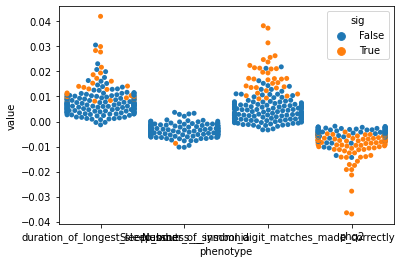

In [244]:
fig, ax = plt.subplots(1,1)
# t_independent['phq2'] = -t_independent['phq2']
# t_fdr_independent['phq2'] = -t_fdr_independent['phq2']

sns.swarmplot(data=t_independent_long, x='phenotype', y='value', hue='sig', ax=ax, dodge=False)
fig.savefig('overlap_swarmp_plot_phenotype.pdf')
# with sns.plotting_context(rc={"markerfacecolor": None}):
#     sns.swarmplot(data=t_independent, marker="$\circ$", ax=ax)
# t_fdr_independent.T.plot(style='.', marker='o', legend=None, ax=ax)

# plt.legend()

In [29]:
# t_independent['phq2'] = -t_independent['phq2']
# t_fdr_independent['phq2'] = -t_fdr_independent['phq2']
t_independent = reorder_to_custom_order(t_independent, roi_region_pd['roi'])
t_independent['index'] = np.arange(180)
# t_independent = reorder_to_roi_order(t_independent, 'lh', None, parcellation='hcp180').iloc[1:, :]
t_independent.index.name = 'roi'
t_independent_roi = t_independent.reset_index()
t_independent_roi
t_independent_roi_long = pd.melt(t_independent_roi, value_vars=['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy', 'Number_of_symbol_digit_matches_made_correctly', 'phq2'],
                            var_name='phenotype', id_vars=['roi', 'index'])
t_fdr_independent = reorder_to_custom_order(t_fdr_independent, roi_region_pd['roi'])
t_fdr_independent_long = pd.melt(t_fdr_independent, value_vars=['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy', 'Number_of_symbol_digit_matches_made_correctly', 'phq2'],
                            var_name='phenotype')
# # t_fdr_independent_long
t_independent_roi_long['sig'] = ~t_fdr_independent_long['value'].isna()
t_independent_roi_long

,roi,index,phenotype,value,sig
0,V1,0,duration_of_longest_sleep_bout,0.009480,False
1,V2,1,duration_of_longest_sleep_bout,0.014471,False
2,V3,2,duration_of_longest_sleep_bout,0.007615,False
3,V4,3,duration_of_longest_sleep_bout,0.028164,False
4,V6,4,duration_of_longest_sleep_bout,0.003578,False
...,...,...,...,...,...
895,a9-46v,175,phq2,-0.008230,True
896,9-46d,176,phq2,-0.002692,False
897,9a,177,phq2,-0.003428,False
898,8Av,178,phq2,-0.004631,False


,r,g,b,primary_section,mean_r,mean_g,mean_b
V1_ROI,0.247059,0.019608,1.000000,NaN,NaN,NaN,NaN
MST_ROI,0.211765,0.403922,0.505882,NaN,NaN,NaN,NaN
V6_ROI,0.243137,0.305882,0.698039,NaN,NaN,NaN,NaN
V2_ROI,0.090196,0.196078,0.913725,NaN,NaN,NaN,NaN
V3_ROI,0.058824,0.156863,0.886275,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
STSva_ROI,0.156863,0.129412,0.086275,NaN,NaN,NaN,NaN
TE1m_ROI,0.231373,0.176471,0.168627,NaN,NaN,NaN,NaN
PI_ROI,0.478431,0.196078,0.196078,NaN,NaN,NaN,NaN
a32pr_ROI,0.509804,0.247059,0.341176,NaN,NaN,NaN,NaN


In [28]:
from nibabel.freesurfer.io import read_annot
_, ctab, roi_names_ctab = read_annot('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/fsaverage/label/lh.HCP-MMP1.annot')
ctab = ctab[1:, :3]
print(ctab)
roi_names_ctab = [str(x[2:])[2:-1].replace('-', '_') for x in roi_names_ctab[1:]]
print(roi_names_ctab)
ctab_df = pd.DataFrame(data=ctab.byteswap().newbyteorder(), columns=['r', 'g', 'b'], index=roi_names_ctab)
ctab_df = ctab_df/255.
ctab_df.loc[['V1_ROI', 'V2_ROI']]

[[ 63   5 255]
 [ 54 103 129]
 [ 62  78 178]
 [ 23  50 233]
 [ 15  40 226]
 [ 14  28 214]
 [ 26  47 201]
 [ 33 178  20]
 [ 35 205  21]
 [134 143 137]
 [141 166 152]
 [ 62  88  47]
 [  7  57 246]
 [153  64 133]
 [186  86 188]
 [ 18  70 195]
 [ 57 114 160]
 [ 57  89 117]
 [ 25  47 206]
 [  0  49 184]
 [ 18  33 181]
 [ 34  43 171]
 [ 31  86 104]
 [235  19  47]
 [122  79  56]
 [ 31  49  22]
 [138 128 153]
 [142  87  76]
 [149 181 188]
 [ 42  31  44]
 [ 81  54  98]
 [127  56  91]
 [ 29   0  14]
 [ 63  17  47]
 [ 54  11  42]
 [ 48 163  48]
 [153 172 136]
 [205 190 194]
 [ 64 154  64]
 [ 69 161  44]
 [119 159  66]
 [115 194 134]
 [110 146  86]
 [144 179 135]
 [184 243 224]
 [169 246 237]
 [ 68 177 108]
 [ 63 113 158]
 [ 50 129 137]
 [136 206 204]
 [ 20 191  38]
 [ 48 176  62]
 [ 47 216  22]
 [ 26 158  32]
 [ 64 159  38]
 [ 71 168  50]
 [146 136 107]
 [129 106 103]
 [176 133 130]
 [163 142 121]
 [ 67  12  25]
 [ 90  41  50]
 [105  83  81]
 [ 95  32  52]
 [ 25  12   1]
 [ 96  75  66]
 [ 53  54 

,r,g,b
V1_ROI,0.247059,0.019608,1.000000
V2_ROI,0.090196,0.196078,0.913725


In [27]:

roi_region_pd = pd.read_csv('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/anatomy_hcp180/roi_list_hcp180.csv', usecols=['roi_id','roi','primary_section'])
roi_region_pd = roi_region_pd.sort_values(by='primary_section')


In [25]:
import re
def reorder_to_custom_order(input_data, target_roi_names):
    roi_names_input = input_data.index
    reordered_data = pd.DataFrame(index=list(target_roi_names.values))
    for idx_target, roi_target in enumerate(target_roi_names.values):
        for idx_source, roi_source in enumerate(roi_names_input):
            input_to_regex = roi_target
            input_to_regex = input_to_regex.replace('?', '\?')
            input_to_regex = input_to_regex.replace('-', '_')

            matching_pattern = re.findall('(^|_| |\n){}(_| |\n|$)'.format(input_to_regex), roi_source)
            if len(matching_pattern) > 0:
                reordered_data.loc[roi_target, input_data.columns] = input_data.loc[roi_source]
    # reordered_data.fillna(-99.0, inplace=True)
    return reordered_data

In [115]:
for x in t_independent.index:
    print(x)

V1
V2
V3
V4
V6
V3B
V6A
IPS1
V7
V3A
VVC
VMV2
FFC
PIT
VMV3
VMV1
V8
V4t
MST
LO3
PH
FST
V3CD
LO2
LO1
MT
4
3b
3a
2
1
24dv
24dd
5L
23c
5mv
SCEF
6mp
6ma
5m
6d
6r
6v
6a
PEF
FEF
55b
43
FOP1
OP4
OP1
OP2-3
52
RI
A1
MBelt
LBelt
PFcm
PBelt
A4
STSdp
STSda
A5
STGa
TA2
STSva
STSvp
PoI2
PI
AVI
MI
Pir
PoI1
Ig
FOP5
AAIC
FOP3
FOP2
FOP4
H
TF
PHA2
PeEc
PHA3
PHA1
EC
PreS
TE1p
TE1a
TGd
PHT
TE2a
TE2p
TE1m
TGv
TPOJ1
PSL
TPOJ3
STV
TPOJ2
7Pm
7AL
7Am
7PL
7PC
AIP
VIP
MIP
LIPv
LIPd
PGs
PGi
PFm
PFt
PF
PFop
IP0
IP1
IP2
PGp
31pv
PCV
DVT
7m
POS1
ProS
v23ab
d23ab
RSC
31pd
31a
23d
POS2
pOFC
s32
25
p24
p32
8BM
9m
a32pr
d32
10v
p24pr
33pr
a24pr
p32pr
a24
10r
47m
p10p
10d
10pp
a10p
11l
13l
OFC
47s
IFJa
a47r
47l
45
44
IFSa
p47r
IFSp
IFJp
SFL
i6-8
8Ad
8BL
9p
s6-8
p9-46v
46
a9-46v
9-46d
9a
8Av
8C


In [116]:
t_independent

,duration_of_longest_sleep_bout,Sleeplessness___insomnia,Daytime_dozing___sleeping_narcolepsy,Number_of_symbol_digit_matches_made_correctly,phq2,accuracy,index
roi,,,,,,,
V1,0.010580,-0.007983,0.002749,0.019670,-0.010827,0.902157,0
V2,0.015188,-0.006725,-0.002289,0.025587,-0.008802,0.914729,1
V3,0.008651,0.003225,-0.005477,0.012067,-0.008132,0.934063,2
V4,0.030534,-0.005481,-0.011042,0.015240,-0.013341,0.958860,3
V6,0.003711,-0.001372,0.001250,0.001457,-0.006235,0.740729,4
...,...,...,...,...,...,...,...
a9-46v,0.004521,-0.003910,0.000606,0.005324,-0.008288,0.760203,175
9-46d,0.011196,-0.003992,0.004815,0.013552,-0.002666,0.763295,176
9a,0.007079,-0.003056,0.000953,0.006835,-0.003085,0.782103,177


In [64]:
t_independent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, roi_hcp180_10d_ROI to roi_hcp180_v23ab_ROI
Data columns (total 6 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   duration_of_longest_sleep_bout                 180 non-null    object 
 1   Sleeplessness___insomnia                       180 non-null    object 
 2   Daytime_dozing___sleeping_narcolepsy           180 non-null    object 
 3   Number_of_symbol_digit_matches_made_correctly  180 non-null    object 
 4   phq2                                           180 non-null    object 
 5   accuracy                                       180 non-null    float64
dtypes: float64(1), object(5)
memory usage: 14.8+ KB


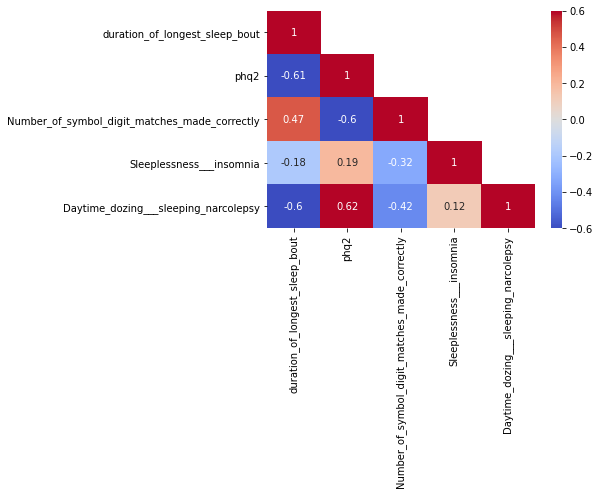

In [27]:
fig, ax = plt.subplots(1,1)
correlation_values = t_independent[['duration_of_longest_sleep_bout', 'phq2', 'Number_of_symbol_digit_matches_made_correctly', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy']].astype(float).corr()
correlation_values.values[np.triu_indices(5,1)] = np.nan
sns.heatmap(correlation_values, 
            annot=True, cmap='coolwarm', center=0.0, vmin=-.6, vmax=.6)
fig.savefig('corr_plot_taskfmri_230330.pdf')

In [37]:
for independent_var0 in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
    for independent_var1 in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
        print(independent_var0, independent_var1, pearsonr_ci(t_independent[independent_var0], t_independent[independent_var1], alpha=0.05/5))

NameError: name 'pearsonr_ci' is not defined

NameError: name 'independent_variables_df' is not defined

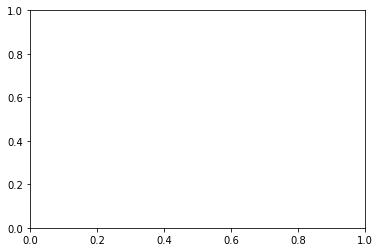

In [48]:
fig, ax = plt.subplots(1,1)
# independent_variables_df['phq2'] = -independent_variables_df['phq2']
correlation_values_ind = independent_variables_df.corr()
correlation_values_ind.values[np.triu_indices(4,1)] = np.nan
sns.heatmap(correlation_values_ind, 
            annot=True, cmap='coolwarm', center=0.0, vmin=-.25, vmax=.25)

fig.savefig('corr_plot_behavioral.pdf')

In [30]:
ctab_df = reorder_to_custom_order(ctab_df, roi_region_pd['roi'])

In [31]:
ctab_df

,r,g,b
V1,0.247059,0.019608,1.000000
V2,0.090196,0.196078,0.913725
V3,0.058824,0.156863,0.886275
V4,0.054902,0.109804,0.839216
V6,0.243137,0.305882,0.698039
...,...,...,...
a9-46v,0.568627,0.439216,0.501961
9-46d,0.549020,0.458824,0.513725
9a,0.215686,0.203922,0.176471
8Av,0.207843,0.211765,0.168627


[(0.24705882352941178, 0.0196078431372549, 1.0),
 (0.09019607843137255, 0.19607843137254902, 0.9137254901960784),
 (0.058823529411764705, 0.1568627450980392, 0.8862745098039215),
 (0.054901960784313725, 0.10980392156862745, 0.8392156862745098),
 (0.24313725490196078, 0.3058823529411765, 0.6980392156862745),
 (0.09803921568627451, 0.1843137254901961, 0.807843137254902),
 (0.1607843137254902, 0.34901960784313724, 0.6509803921568628),
 (0.2235294117647059, 0.4470588235294118, 0.6274509803921569),
 (0.07058823529411765, 0.27450980392156865, 0.7647058823529411),
 (0.027450980392156862, 0.2235294117647059, 0.9647058823529412),
 (0.20784313725490197, 0.23921568627450981, 0.48627450980392156),
 (0.2627450980392157, 0.24313725490196078, 0.6313725490196078),
 (0.2235294117647059, 0.34901960784313724, 0.4588235294117647),
 (0.13333333333333333, 0.16862745098039217, 0.6705882352941176),
 (0.19215686274509805, 0.20784313725490197, 0.6235294117647059),
 (0.24313725490196078, 0.23921568627450981, 0.6078431372549019),
 (0.10196078431372549, 0.1843137254901961, 0.788235294117647),
 (0.054901960784313725, 0.30980392156862746, 0.5019607843137255),
 (0.21176470588235294, 0.403921568627451, 0.5058823529411764),
 (0.21176470588235294, 0.3686274509803922, 0.6274509803921569),
 (0.34509803921568627, 0.5137254901960784, 0.6392156862745098),
 (0.3607843137254902, 0.615686274509804, 0.6),
 (0.058823529411764705, 0.1803921568627451, 0.7137254901960784),
 (0.07058823529411765, 0.12941176470588237, 0.7098039215686275),
 (0.0, 0.19215686274509805, 0.7215686274509804),
 (0.12156862745098039, 0.33725490196078434, 0.40784313725490196),
 (0.12941176470588237, 0.6980392156862745, 0.0784313725490196),
 (0.13725490196078433, 0.803921568627451, 0.08235294117647059),
 (0.1843137254901961, 0.8470588235294118, 0.08627450980392157),
 (0.18823529411764706, 0.6901960784313725, 0.24313725490196078),
 (0.0784313725490196, 0.7490196078431373, 0.14901960784313725),
 (0.4666666666666667, 0.6235294117647059, 0.25882352941176473),
 (0.27058823529411763, 0.6313725490196078, 0.17254901960784313),
 (0.25098039215686274, 0.6039215686274509, 0.25098039215686274),
 (0.803921568627451, 0.7450980392156863, 0.7607843137254902),
 (0.6, 0.6745098039215687, 0.5333333333333333),
 (0.43137254901960786, 0.5725490196078431, 0.33725490196078434),
 (0.25098039215686274, 0.6235294117647059, 0.14901960784313725),
 (0.5647058823529412, 0.7019607843137254, 0.5294117647058824),
 (0.18823529411764706, 0.6392156862745098, 0.18823529411764706),
 (0.10196078431372549, 0.6196078431372549, 0.12549019607843137),
 (0.6980392156862745, 0.8392156862745098, 0.592156862745098),
 (0.2784313725490196, 0.6588235294117647, 0.19607843137254902),
 (0.4745098039215686, 0.7529411764705882, 0.5333333333333333),
 (0.5529411764705883, 0.6509803921568628, 0.596078431372549),
 (0.5254901960784314, 0.5607843137254902, 0.5372549019607843),
 (0.24313725490196078, 0.34509803921568627, 0.1843137254901961),
 (0.5686274509803921, 0.5411764705882353, 0.25098039215686274),
 (0.6274509803921569, 0.6, 0.34509803921568627),
 (0.4470588235294118, 0.615686274509804, 0.19215686274509805),
 (0.38823529411764707, 0.6196078431372549, 0.13725490196078433),
 (0.5686274509803921, 0.4980392156862745, 0.20392156862745098),
 (0.8156862745098039, 0.2823529411764706, 0.25882352941176473),
 (0.6980392156862745, 0.23921568627450981, 0.09019607843137255),
 (0.9215686274509803, 0.07450980392156863, 0.1843137254901961),
 (0.7333333333333333, 0.11764705882352941, 0.09411764705882353),
 (0.9137254901960784, 0.07058823529411765, 0.10588235294117647),
 (0.7450980392156863, 0.5647058823529412, 0.34901960784313724),
 (0.7647058823529411, 0.11764705882352941, 0.0196078431372549),
 (0.596078431372549, 0.15294117647058825, 0.01568627450980392),
 (0.28627450980392155, 0.2235294117647059, 0.15294117647058825),
 (0.30196078431372547, 0.2, 0.13333333333333333),
 (0.38823529411764707, 0.15294117647058825, 0.023529411764705882),
 (0.22745098039215686, 0.1647058823529411

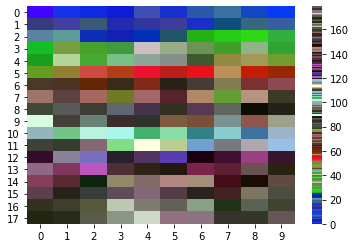

In [32]:
color_map_hcp180 = sns.color_palette(ctab_df.values)
sns.heatmap(np.arange(180).reshape(18,10), cmap=color_map_hcp180)
color_map_hcp180

In [33]:
from matplotlib.colors import ListedColormap
ListedColormap(ctab_df.values)

(-0.1, 0.1)

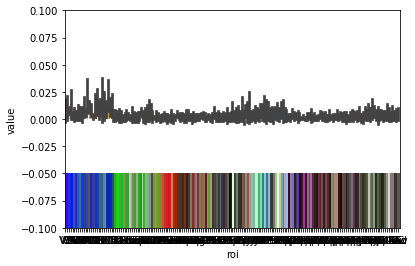

In [277]:
fig, ax = plt.subplots(1,1)
sns.barplot(data=t_independent_roi_long, x='roi', y='value', ax=ax)
# sns.heatmap(data=np.expand_dims(t_independent_roi_long['index'].unique(), axis=0), cmap=color_map_hcp180, ax=ax)
ax.imshow(np.expand_dims(t_independent_roi_long['index'].unique(), axis=0), zorder=0, aspect="auto", extent=(0,180,-0.1,-0.05), 
          cmap=ListedColormap(ctab_df.values))
ax.set_ylim(-0.1, 0.1)

In [34]:
ctab_df['primary_section'] = roi_region_pd.set_index('roi')['primary_section']
# ctab_df[['mean_r', 'mean_g', 'mean_b']] = ctab_df.groupby('primary_section').mean()
ctab_df['mean_r'] = ctab_df['primary_section'].map(ctab_df.groupby('primary_section')['r'].apply(lambda x: x.mean()))
ctab_df['mean_g'] = ctab_df['primary_section'].map(ctab_df.groupby('primary_section')['g'].apply(lambda x: x.mean()))
ctab_df['mean_b'] = ctab_df['primary_section'].map(ctab_df.groupby('primary_section')['b'].apply(lambda x: x.mean()))

ctab_df


,r,g,b,primary_section,mean_r,mean_g,mean_b
V1,0.247059,0.019608,1.000000,1,0.247059,0.019608,1.000000
V2,0.090196,0.196078,0.913725,2,0.067974,0.154248,0.879739
V3,0.058824,0.156863,0.886275,2,0.067974,0.154248,0.879739
V4,0.054902,0.109804,0.839216,2,0.067974,0.154248,0.879739
V6,0.243137,0.305882,0.698039,3,0.137255,0.297386,0.752288
...,...,...,...,...,...,...,...
a9-46v,0.568627,0.439216,0.501961,22,0.356863,0.354148,0.313424
9-46d,0.549020,0.458824,0.513725,22,0.356863,0.354148,0.313424
9a,0.215686,0.203922,0.176471,22,0.356863,0.354148,0.313424
8Av,0.207843,0.211765,0.168627,22,0.356863,0.354148,0.313424


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(-0.06, 0.06)

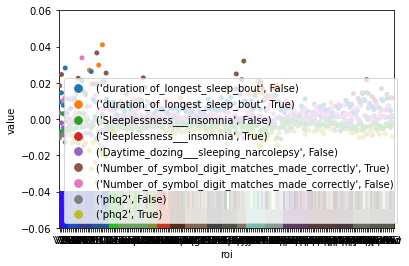

In [35]:
fig, ax = plt.subplots(1,1)

sns.swarmplot(data=t_independent_roi_long, x='roi', y='value', hue=t_independent_roi_long[['phenotype', 'sig']].apply(tuple, axis=1), ax=ax, dodge=False)
# ax2 = ax.twinx()
# sns.pointplot(data=t_independent_roi_long, x='roi', y='accuracy', ax=ax2, markers='_', dodge=False, ci=None, color='k')
ax.imshow(np.expand_dims(t_independent_roi_long['index'].unique(), axis=0), zorder=0, aspect="auto", extent=(0,180,-0.05,-0.04), 
          cmap=ListedColormap(ctab_df[['r', 'g', 'b']].values))
ax.imshow(np.expand_dims(t_independent_roi_long['index'].unique(), axis=0), zorder=0, aspect="auto", extent=(0,180,-0.06,-0.05), 
          cmap=ListedColormap(ctab_df[['mean_r', 'mean_g', 'mean_b']].values))
ax.set_ylim(-0.06, 0.06)
# ax2.set_ylim(-1, 1)
# fig.savefig('overlap_swarmp_plot_phenotype.pdf')
# with sns.plotting_context(rc={"markerfacecolor": None}):
#     sns.swarmplot(data=t_independent, marker="$\circ$", ax=ax)
# t_fdr_independent.T.plot(style='.', marker='o', legend=None, ax=ax)

# plt.legend()

In [36]:
fig.savefig('overlap_swarm_plot_roi_230316.pdf')

In [38]:
t_independent_roi_long['value'].max()

0.04100983609225666

### Check which independent variables are closer to each other via MDS

In [357]:
from sklearn import manifold
from datetime import datetime
start = datetime.now()
mds = manifold.MDS(
    metric=False,
    n_components=2,
    max_iter=50000,
    eps=1e-9,
    random_state=42,
    dissimilarity="euclidean",
    n_jobs=2,
)
t_independent_mds = t_independent[['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2']].copy(deep=True)
# t_independent_mds = t_independent_mds.abs()

npos_brain = mds.fit_transform(t_independent_mds.values.T)
npos_brain /= np.sqrt((npos_brain ** 2).sum())
print('Time = {}'.format(datetime.now()-start))

Time = 0:00:00.437774


In [358]:
npos_brain

array([[ 0.07576278,  0.60341245],
       [-0.32972332, -0.13720361],
       [ 0.5100481 , -0.0484018 ],
       [-0.25606488, -0.41779193]])

In [128]:
from sklearn import manifold
from datetime import datetime
start = datetime.now()
mds = manifold.MDS(
    metric=False,
    n_components=2,
    max_iter=50000,
    eps=1e-9,
    random_state=42,
    dissimilarity="euclidean",
    n_jobs=2,
)
t_independent_mds = t_fdr_independent.copy(deep=True).fillna(0.0)
t_independent_mds = t_independent_mds.abs()

npos_brain_fdr = mds.fit_transform(t_independent_mds.values.T)
npos_brain_fdr /= np.sqrt((npos_brain_fdr ** 2).sum())
print('Time = {}'.format(datetime.now()-start))

Time = 0:00:00.259540


In [129]:
npos_brain_fdr

array([[ 0.37754488,  0.164414  ],
       [ 0.2011    , -0.2201013 ],
       [ 0.08538468, -0.35410204],
       [-0.66402779,  0.40979312]])

In [361]:
independent_variables = ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2']
independent_variables_df = tabular_tfmri.loc[:, independent_variables].dropna()
start = datetime.now()
mds = manifold.MDS(
    metric=False,
    n_components=2,
    max_iter=50000,
    eps=1e-9,
    random_state=42,
    dissimilarity="euclidean",
    n_jobs=2,
)

npos_behav = mds.fit_transform(independent_variables_df.values.T)
npos_behav /= np.sqrt((npos_behav ** 2).sum())
print('Time = {}'.format(datetime.now()-start))

Time = 0:00:00.250100


In [362]:
npos_behav

array([[ 0.2024212 ,  0.19860648],
       [ 0.20247216,  0.19858728],
       [ 0.20538195, -0.61430696],
       [-0.61028755,  0.21712567]])

(-1.0, 1.0)

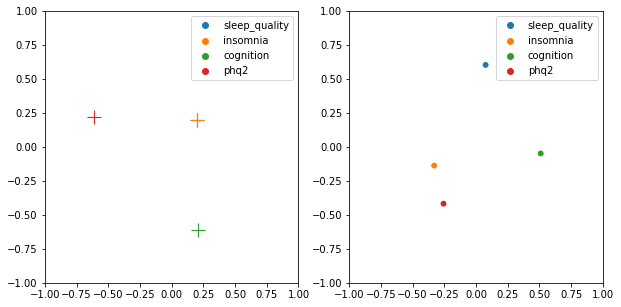

In [365]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x=npos_behav[:,0], y=npos_behav[:,1], hue=['sleep_quality', 'insomnia', 'cognition', 'phq2'], marker='+', s=200, ax=axs[0])
sns.scatterplot(x=npos_brain[:,0], y=npos_brain[:,1], hue=['sleep_quality', 'insomnia', 'cognition', 'phq2'], marker='.', s=200, ax=axs[1])
# sns.scatterplot(x=npos_brain_fdr[:,0], y=npos_brain_fdr[:,1], hue=['sleep_quality', 'insomnia', 'cognition', 'phq2'], marker='.', s=200, ax=axs[2])

axs[0].set_xlim(-1,1)

axs[0].set_ylim(-1,1)
axs[1].set_xlim(-1,1)
axs[1].set_ylim(-1,1)
# axs[2].set_xlim(-1,1)
# axs[2].set_ylim(-1,1)
# plt.legend(['sleep_quality', 'insomnia', 'cognition', 'phq2'])

In [307]:
# aggregated_results.set_index('ID', inplace=True)
aggregated_results_1 = aggregated_results.iloc[:, -3:]
print(aggregated_results_1.dropna().index)

Index(['4062461', '4238500', '5234734', '5754236', '5648269', '4924232',
       '4836436', '2730911', '4640349', '5961556',
       ...
       '2637284', '4595750', '3829377', '5102218', '2742085', '4018561',
       '3427895', '5386494', '5269256', '5910103'],
      dtype='object', name='ID', length=801)


<class 'pandas.core.frame.DataFrame'>
Index: 19444 entries, 3037925 to 3848632
Columns: 183 entries, roi_hcp180_10d_ROI to roi_aseg_L_thalamus + roi_aseg_R_thalamus
dtypes: float64(183)
memory usage: 27.3+ MB


In [308]:
aggregated_results_1.index

Index(['3037925', '1931773', '4602292', '5944927', '1882172', '4796996',
       '3529333', '1830116', '5512741', '4102582',
       ...
       '4334785', '4245801', '2251882', '3040790', '3427843', '5602748',
       '4771218', '1270261', '5363464', '3848632'],
      dtype='object', name='ID', length=19444)

In [61]:
def allvalid_make_ols_maps(data, indep_variable, output_list, accuracy_data, save=True):
    data_copy = data.copy(deep=True)
    data_copy[independent_var] = (data_copy[indep_variable] - data[indep_variable].mean() ) / data_copy[indep_variable].std()


    pt_values = dict()

    for idx, roi in enumerate(output_list):
        phenotype_name = roi
        if indep_variable == 'duration_of_longest_sleep_bout':
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + actigraphy_time + head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                               data=data_copy)
        else:
        
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                                   data=data_copy)
        lr_results = lr_model.fit()
#         print(lr_results.params)
#         print(lr_results.conf_int(0.05))
#         break
        for idx2 , var in enumerate(lr_results.pvalues.keys()):
            if var not in pt_values.keys():
                pt_values[var] = pd.DataFrame(index=output_list, columns=['p', 't', 'beta', 'conf_interval_lower', 'conf_interval_higher'])
            pt_values[var].loc[roi, 'p'] = lr_results.pvalues[var]
            pt_values[var].loc[roi, 't'] = lr_results.tvalues[var]
            pt_values[var].loc[roi, 'beta'] = lr_results.params[var]
            pt_values[var].loc[roi, 'conf_interval_lower'] = lr_results.conf_int(0.05).loc[var, 0]
            pt_values[var].loc[roi, 'conf_interval_higher'] = lr_results.conf_int(0.05).loc[var, 1]
    for idx, variable in enumerate(pt_values.keys()):
        pt_values[variable]['p_fdr'] = fdrcorrection(pt_values[variable]['p'], alpha=0.05, method='i')[1]
        pt_values[variable]['t_sig'] = pt_values[variable]['t']
        pt_values[variable]['t_bonf'] = pt_values[variable]['t']
        pt_values[variable]['beta_sig'] = pt_values[variable]['beta']
        pt_values[variable]['beta_bonf'] = pt_values[variable]['beta']
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 't_sig'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 'beta_sig'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p'] >=(0.05)/(180*4), 't_bonf'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p'] >=(0.05)/(180*4), 'beta_bonf'] = np.nan
        pt_values[variable]['accuracy_mean'] = accuracy_data.mean()
        pt_values[variable]['t_normalized_by_acc'] = pt_values[variable]['t'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['t_sig_normalized_by_acc'] = pt_values[variable]['t_sig'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['t_bonf_normalized_by_acc'] = pt_values[variable]['t_bonf'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_normalized_by_acc'] = pt_values[variable]['beta'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_sig_normalized_by_acc'] = pt_values[variable]['beta_sig'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_bonf_normalized_by_acc'] = pt_values[variable]['beta_bonf'] / (1 - pt_values[variable]['accuracy_mean'])
        
        pt_values[variable].to_csv('results/task/stats/{}_{}_stats.csv'.format(independent_var, variable))

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_sig_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_beta_sig_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_beta_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_bonf_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_beta_bonf_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_beta'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_beta_sig'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_beta_bonf'.format(independent_var, variable), parcellation='hcp180')
        

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_t_sig_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_t_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_t_bonf_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_t'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_t_sig'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', 'allvalid_{}_{}_svm_hcp180_t_bonf'.format(independent_var, variable), parcellation='hcp180')

    
    return pt_values

In [62]:
with open('valid_subjects_4variables_221102.txt', 'r') as f:
    allvalid_subj_list = f.readlines()
allvalid_subj_list = [int(s.strip()) for s in allvalid_subj_list]
len(allvalid_subj_list)

7589

In [63]:
independent_var = 'duration_of_longest_sleep_bout'
longest_sleep_bout_stats = allvalid_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results)

In [64]:
independent_var = 'phq2'
longest_sleep_bout_stats = allvalid_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results)

In [65]:
independent_var = 'Number_of_symbol_digit_matches_made_correctly'
cogntive_stats = allvalid_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results)

In [66]:
independent_var = 'Sleeplessness___insomnia'
sleep_stats = allvalid_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results)

In [67]:
def valid3_make_ols_maps(data, indep_variable, output_list, accuracy_data, save=True):
    data_copy = data.copy(deep=True)
    data_copy[independent_var] = (data_copy[indep_variable] - data[indep_variable].mean() ) / data_copy[indep_variable].std()


    pt_values = dict()

    for idx, roi in enumerate(output_list):
        phenotype_name = roi
        if indep_variable == 'duration_of_longest_sleep_bout':
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + actigraphy_time + head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                               data=data_copy)
        else:
        
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + head_motion + response_time_mean_y + accuracy_mean_y + response_time_std_y'.format(phenotype_name, indep_variable),
                                   data=data_copy)
        lr_results = lr_model.fit()
#         print(lr_results.params)
#         print(lr_results.conf_int(0.05))
#         break
        for idx2 , var in enumerate(lr_results.pvalues.keys()):
            if var not in pt_values.keys():
                pt_values[var] = pd.DataFrame(index=output_list, columns=['p', 't', 'beta', 'conf_interval_lower', 'conf_interval_higher'])
            pt_values[var].loc[roi, 'p'] = lr_results.pvalues[var]
            pt_values[var].loc[roi, 't'] = lr_results.tvalues[var]
            pt_values[var].loc[roi, 'beta'] = lr_results.params[var]
            pt_values[var].loc[roi, 'conf_interval_lower'] = lr_results.conf_int(0.05).loc[var, 0]
            pt_values[var].loc[roi, 'conf_interval_higher'] = lr_results.conf_int(0.05).loc[var, 1]
    for idx, variable in enumerate(pt_values.keys()):
        pt_values[variable]['p_fdr'] = fdrcorrection(pt_values[variable]['p'], alpha=0.05, method='i')[1]
        pt_values[variable]['t_sig'] = pt_values[variable]['t']
        pt_values[variable]['t_bonf'] = pt_values[variable]['t']
        pt_values[variable]['beta_sig'] = pt_values[variable]['beta']
        pt_values[variable]['beta_bonf'] = pt_values[variable]['beta']
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 't_sig'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 'beta_sig'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p'] >=(0.05)/(180*4), 't_bonf'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p'] >=(0.05)/(180*4), 'beta_bonf'] = np.nan
        pt_values[variable]['accuracy_mean'] = accuracy_data.mean()
        pt_values[variable]['t_normalized_by_acc'] = pt_values[variable]['t'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['t_sig_normalized_by_acc'] = pt_values[variable]['t_sig'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['t_bonf_normalized_by_acc'] = pt_values[variable]['t_bonf'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_normalized_by_acc'] = pt_values[variable]['beta'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_sig_normalized_by_acc'] = pt_values[variable]['beta_sig'] / (1 - pt_values[variable]['accuracy_mean'])
        pt_values[variable]['beta_bonf_normalized_by_acc'] = pt_values[variable]['beta_bonf'] / (1 - pt_values[variable]['accuracy_mean'])
        
        pt_values[variable].to_csv('results/task/stats/{}_{}_stats.csv'.format(independent_var, variable))

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_sig_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_beta_sig_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_beta_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_bonf_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_beta_bonf_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_beta'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_beta_sig'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['beta_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_beta_bonf'.format(independent_var, variable), parcellation='hcp180')
        

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_t_sig_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_t_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf_normalized_by_acc'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_t_bonf_normalized_by_acc'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_t'.format(independent_var, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_t_sig'.format(independent_var, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        if save:
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'task', '3valid_{}_{}_svm_hcp180_t_bonf'.format(independent_var, variable), parcellation='hcp180')

    
    return pt_values

In [69]:
with open('valid_subjects_3variables_221102.txt', 'r') as f:
    allvalid_subj_list = f.readlines()
allvalid_subj_list = [int(s.strip()) for s in allvalid_subj_list]
len(allvalid_subj_list)

12914

In [70]:
independent_var = 'duration_of_longest_sleep_bout'
longest_sleep_bout_stats = valid3_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results)

In [71]:
independent_var = 'phq2'
phq2_stats = valid3_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results)

In [72]:
independent_var = 'Sleeplessness___insomnia'
sleep_stats = valid3_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results)

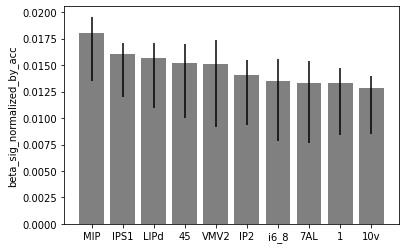

In [73]:
plot_betas_top_rois(phq2_stats['phq2'], 'phq2', top_x=10
                    , save=False)

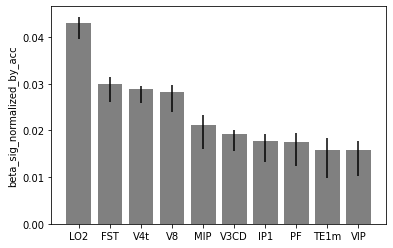

In [74]:
plot_betas_top_rois(longest_sleep_bout_stats['duration_of_longest_sleep_bout'], 'duration_of_longest_sleep_bout', top_x=10
                    , save=False)

In [75]:
t_fdr_independent_noperf = pd.DataFrame()
t_independent_noperf = pd.DataFrame()
for independent_var in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'phq2']:
    data_stats = valid3_make_ols_maps(tabular_tfmri.loc[allvalid_subj_list, :], independent_var, roi_list, aggregated_results, save=False)
    t_fdr_independent[independent_var] = data_stats[independent_var]['beta_sig_normalized_by_acc']
    t_independent[independent_var] = data_stats[independent_var]['beta']

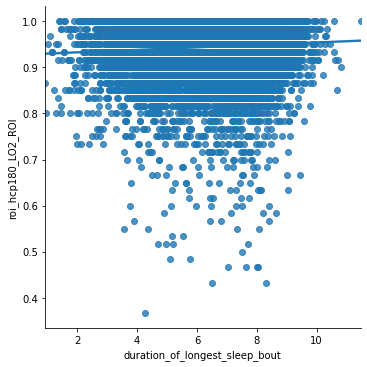

In [91]:
sns.lmplot(data=tabular_tfmri, x='duration_of_longest_sleep_bout', y='roi_hcp180_LO2_ROI')

In [66]:
tabular_tfmri['phq2'].value_counts()

4.0     23188
5.0      2887
6.0      2631
7.0       411
8.0       291
10.0      151
9.0        91
Name: phq2, dtype: int64

In [80]:
t_fdr_independent_noperf = pd.DataFrame()
t_independent_noperf = pd.DataFrame()
for independent_var in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
    data_stats = make_ols_maps(tabular_tfmri.loc[tabular_tfmri['phq2'] < 7], independent_var, roi_list, aggregated_results, save=False)
    t_fdr_independent_noperf[independent_var] = data_stats[independent_var]['beta_normalized_by_acc']
    t_independent_noperf[independent_var] = data_stats[independent_var]['beta']
    

<AxesSubplot:>

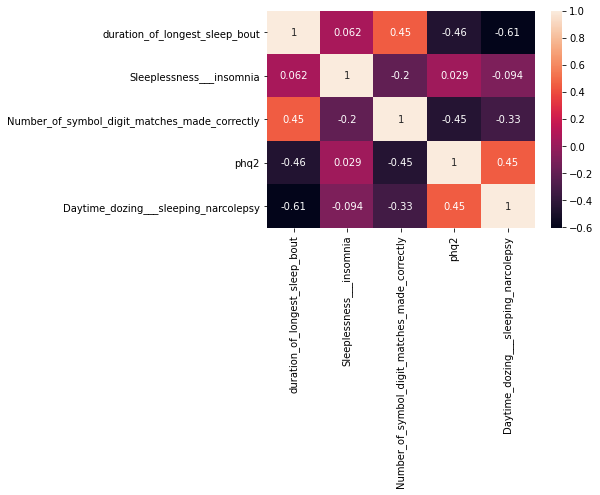

In [77]:
sns.heatmap(t_fdr_independent_noperf.astype('float64').corr(), annot=True)

In [75]:
t_fdr_independent_noperf.corr()

duration_of_longest_sleep_bout                   0
Sleeplessness___insomnia                         0
Number_of_symbol_digit_matches_made_correctly    0
phq2                                             0
Daytime_dozing___sleeping_narcolepsy             0
dtype: int64

<AxesSubplot:>

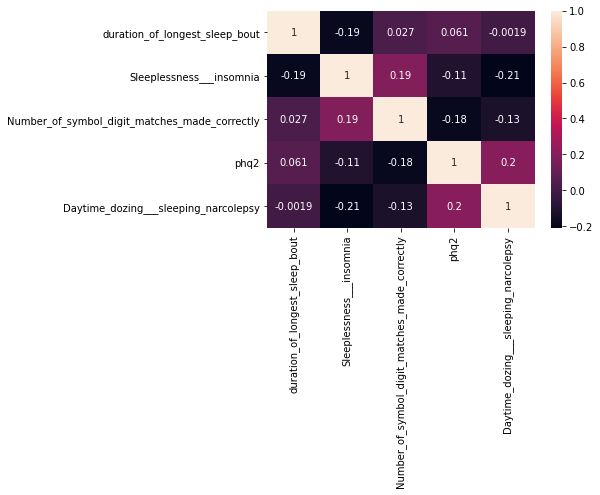

In [79]:
sns.heatmap(t_fdr_independent_noperf.astype('float64').corr(), annot=True)

In [23]:
from scipy import stats
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [82]:
print(pearsonr_ci(t_fdr_independent_noperf['duration_of_longest_sleep_bout'], t_fdr_independent_noperf['Sleeplessness___insomnia']))

(0.062258349106875645, 0.40638612809627317, -0.0847769563758177, 0.20663997914678198)


In [86]:
t_fdr_independent_lowsleep = pd.DataFrame()
t_independent_lowsleep = pd.DataFrame()
for independent_var in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
    data_stats = make_ols_maps(tabular_tfmri.loc[tabular_tfmri['duration_of_longest_sleep_bout'] < 7], independent_var, roi_list, aggregated_results, save=False)
    t_fdr_independent_lowsleep[independent_var] = data_stats[independent_var]['beta_normalized_by_acc']
    t_independent_lowsleep[independent_var] = data_stats[independent_var]['beta']

<AxesSubplot:>

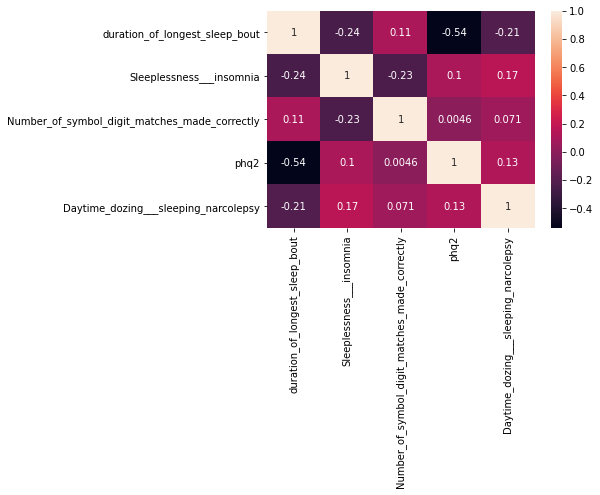

In [84]:
sns.heatmap(t_fdr_independent_lowsleep.astype('float64').corr(), annot=True)

In [92]:
for independent_var0 in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
    for independent_var1 in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
        print(independent_var0, independent_var1, pearsonr_ci(t_fdr_independent_lowsleep[independent_var0], t_fdr_independent_lowsleep[independent_var1]))

duration_of_longest_sleep_bout duration_of_longest_sleep_bout (0.9999999999999999, 0.0, 0.9999999999999999, 0.9999999999999999)
duration_of_longest_sleep_bout Sleeplessness___insomnia (-0.2413620157252518, 0.0010983362383334447, -0.37440783419385143, -0.09857876669909828)
duration_of_longest_sleep_bout Number_of_symbol_digit_matches_made_correctly (0.10891349531132828, 0.1455638401259359, -0.03795443771236055, 0.251175573070775)
duration_of_longest_sleep_bout phq2 (-0.5425610579021622, 3.624816711405319e-15, -0.6381804308291203, -0.430457458784549)
duration_of_longest_sleep_bout Daytime_dozing___sleeping_narcolepsy (-0.21406672101297203, 0.003907632369175404, -0.349390580924589, -0.06999495365008422)
Sleeplessness___insomnia duration_of_longest_sleep_bout (-0.2413620157252518, 0.0010983362383334447, -0.37440783419385143, -0.09857876669909828)
Sleeplessness___insomnia Sleeplessness___insomnia (0.9999999999999999, 0.0, 0.9999999999999999, 0.9999999999999999)
Sleeplessness___insomnia Numb

/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in arctanh


In [87]:
t_fdr_independent_hisleep = pd.DataFrame()
t_independent_hisleep = pd.DataFrame()
for independent_var in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
    data_stats = make_ols_maps(tabular_tfmri.loc[tabular_tfmri['duration_of_longest_sleep_bout'] >= 7], independent_var, roi_list, aggregated_results, save=False)
    t_fdr_independent_hisleep[independent_var] = data_stats[independent_var]['beta_normalized_by_acc']
    t_independent_hisleep[independent_var] = data_stats[independent_var]['beta']

<AxesSubplot:>

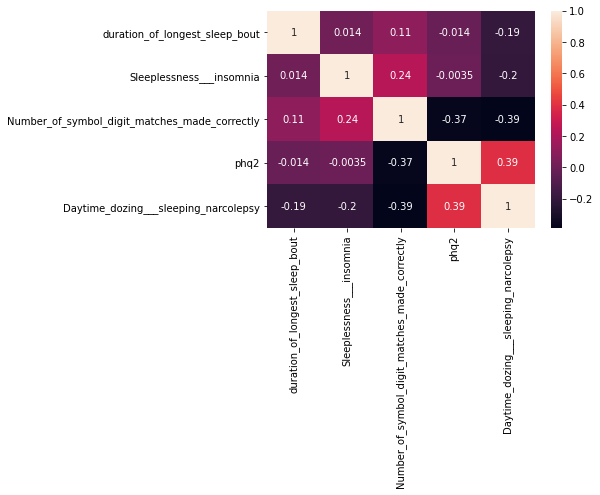

In [88]:
sns.heatmap(t_fdr_independent_hisleep.astype('float64').corr(), annot=True)

In [93]:
for independent_var0 in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
    for independent_var1 in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
        print(independent_var0, independent_var1, pearsonr_ci(t_fdr_independent_hisleep[independent_var0], t_fdr_independent_hisleep[independent_var1]))

duration_of_longest_sleep_bout duration_of_longest_sleep_bout (0.9999999999999998, 0.0, 0.9999999999999997, 0.9999999999999999)
duration_of_longest_sleep_bout Sleeplessness___insomnia (0.014388045770529838, 0.8479764359426653, -0.1321533804933697, 0.16031399103421765)
duration_of_longest_sleep_bout Number_of_symbol_digit_matches_made_correctly (0.1084525530414129, 0.14728598646918362, -0.038420209499707855, 0.25073849795400954)
duration_of_longest_sleep_bout phq2 (-0.013886752063172565, 0.8532123481399628, -0.15982544398868231, 0.1326459851388586)
duration_of_longest_sleep_bout Daytime_dozing___sleeping_narcolepsy (-0.19310333578296837, 0.009398833015506272, -0.3300448866210288, -0.0482014164600257)
Sleeplessness___insomnia duration_of_longest_sleep_bout (0.014388045770529838, 0.8479764359426653, -0.1321533804933697, 0.16031399103421765)
Sleeplessness___insomnia Sleeplessness___insomnia (1.0, 0.0, 1.0, 1.0)
Sleeplessness___insomnia Number_of_symbol_digit_matches_made_correctly (0.23966

/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in arctanh


In [109]:
aggregated_results_bd['G47'].value_counts()

0.0    28015
1.0      289
Name: G47, dtype: int64

In [101]:
tabular_tfmri['phq2'].value_counts()

4.0     23188
5.0      2887
6.0      2631
7.0       411
8.0       291
10.0      151
9.0        91
Name: phq2, dtype: int64

In [23]:
roi_list_presentable = [x.split('_', 2)[2][:-4].replace('_', '-') for x in data_stats['Daytime_dozing___sleeping_narcolepsy'].index]
roi_list_presentable

['10d',
 '10pp',
 '10r',
 '10v',
 '11l',
 '13l',
 '1',
 '23c',
 '23d',
 '24dd',
 '24dv',
 '25',
 '2',
 '31a',
 '31pd',
 '31pv',
 '33pr',
 '3a',
 '3b',
 '43',
 '44',
 '45',
 '46',
 '47l',
 '47m',
 '47s',
 '4',
 '52',
 '55b',
 '5L',
 '5m',
 '5mv',
 '6a',
 '6d',
 '6ma',
 '6mp',
 '6r',
 '6v',
 '7AL',
 '7Am',
 '7PC',
 '7PL',
 '7Pm',
 '7m',
 '8Ad',
 '8Av',
 '8BL',
 '8BM',
 '8C',
 '9-46d',
 '9a',
 '9m',
 '9p',
 'A1',
 'A4',
 'A5',
 'AAIC',
 'AIP',
 'AVI',
 'DVT',
 'EC',
 'FEF',
 'FFC',
 'FOP1',
 'FOP2',
 'FOP3',
 'FOP4',
 'FOP5',
 'FST',
 'H',
 'IFJa',
 'IFJp',
 'IFSa',
 'IFSp',
 'IP0',
 'IP1',
 'IP2',
 'IPS1',
 'Ig',
 'LBelt',
 'LIPd',
 'LIPv',
 'LO1',
 'LO2',
 'LO3',
 'MBelt',
 'MIP',
 'MI',
 'MST',
 'MT',
 'OFC',
 'OP1',
 'OP2-3',
 'OP4',
 'PBelt',
 'PCV',
 'PEF',
 'PF',
 'PFcm',
 'PFm',
 'PFop',
 'PFt',
 'PGi',
 'PGp',
 'PGs',
 'PHA1',
 'PHA2',
 'PHA3',
 'PHT',
 'PH',
 'PIT',
 'PI',
 'POS1',
 'POS2',
 'PSL',
 'PeEc',
 'Pir',
 'PoI1',
 'PoI2',
 'PreS',
 'ProS',
 'RI',
 'RSC',
 'SCEF',
 'SF

In [24]:
variables_presentable = ['Duration of longest sleep bout', 'PHQ-2', 'Cognition', 'Self-report insomnia', 'Self-report daytime dozing']
assoc_stats_df = pd.DataFrame(columns=['Variable', 'Region', 'Decoding accuracy', 'Coefficient', 'Coefficient normalized by accuracy', 't-value', 'p-value (raw)', 'p-value (FDR)', 'Significant'],
                                 index=np.arange(180 * 5))
for idx, var in enumerate(['duration_of_longest_sleep_bout', 'phq2', 'Number_of_symbol_digit_matches_made_correctly', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy']):
    data_stats = make_ols_maps(tabular_tfmri, var, roi_list, aggregated_results, save=False)
#     roi_list_presentable = [x.split('_')[2] for x in data_stats[var].index]
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Variable'] = variables_presentable[idx]
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Region'] = roi_list_presentable
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Decoding accuracy'] = data_stats[var]['accuracy_mean'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Coefficient'] = data_stats[var]['beta'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Coefficient normalized by accuracy'] = data_stats[var]['beta_normalized_by_acc'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 't-value'] = data_stats[var]['t'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'p-value (raw)'] = data_stats[var]['p'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'p-value (FDR)'] = data_stats[var]['p_fdr'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Significant'] = data_stats[var]['p_fdr'].values < 0.01
assoc_stats_df.to_csv('./stats_supplement/task_fmri_decoding_association_statistics.csv'.format(var), index=False)



In [16]:

for independent_var in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy', 'Number_of_symbol_digit_matches_made_correctly', 'phq2']:
    data_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results, save=False)
    break
data_stats

{'Intercept':                               p         t         beta conf_interval_lower  \
 roi_hcp180_10d_ROI     0.857629 -0.179397 -2.88061e+09        -3.43551e+10   
 roi_hcp180_10pp_ROI    0.152998   1.42911  2.40565e+10        -8.93913e+09   
 roi_hcp180_10r_ROI     0.143576   1.46269  2.43131e+10        -8.26877e+09   
 roi_hcp180_10v_ROI     0.394539  0.851444  1.37593e+10        -1.79166e+10   
 roi_hcp180_11l_ROI     0.377837 -0.881919 -1.47904e+10        -4.76633e+10   
 ...                         ...       ...          ...                 ...   
 roi_hcp180_p9_46v_ROI  0.827424  0.218011  3.54875e+09        -2.83583e+10   
 roi_hcp180_pOFC_ROI    0.820283 -0.227185 -4.12059e+09        -3.96729e+10   
 roi_hcp180_s32_ROI      0.83801 -0.204444 -3.66528e+09         -3.8807e+10   
 roi_hcp180_s6_8_ROI    0.222713    1.2194  2.22924e+10        -1.35418e+10   
 roi_hcp180_v23ab_ROI   0.221464    1.2227  2.21962e+10        -1.33871e+10   
 
                       conf_interval_

In [17]:
data_stats[independent_var]

,p,t,beta,conf_interval_lower,conf_interval_higher,p_fdr,t_sig,t_bonf,beta_sig,beta_bonf,accuracy_mean,t_normalized_by_acc,t_sig_normalized_by_acc,t_bonf_normalized_by_acc,beta_normalized_by_acc,beta_sig_normalized_by_acc,beta_bonf_normalized_by_acc
roi_hcp180_10d_ROI,0.0657317,1.84041,0.00155412,-0.000101116,0.00320935,0.106592,NaN,NaN,NaN,NaN,0.790765,8.79587,NaN,NaN,0.00742762,NaN,NaN
roi_hcp180_10pp_ROI,0.384572,0.869532,0.00076976,-0.000965475,0.00250499,0.424681,NaN,NaN,NaN,NaN,0.763467,3.67616,NaN,NaN,0.00325434,NaN,NaN
roi_hcp180_10r_ROI,0.481115,0.704531,0.000615871,-0.00109761,0.00232935,0.51243,NaN,NaN,NaN,NaN,0.776091,3.14651,NaN,NaN,0.00275054,NaN,NaN
roi_hcp180_10v_ROI,0.0495757,1.96379,0.00166892,3.09629e-06,0.00333474,0.0858042,NaN,NaN,NaN,NaN,0.784642,9.11873,NaN,NaN,0.00774952,NaN,NaN
roi_hcp180_11l_ROI,0.00763681,2.66814,0.0023532,0.000624422,0.00408198,0.0292473,NaN,NaN,NaN,NaN,0.772188,11.712,NaN,NaN,0.0103296,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
roi_hcp180_p9_46v_ROI,0.0160515,2.40806,0.00206142,0.000383435,0.0037394,0.0430361,NaN,NaN,NaN,NaN,0.812764,12.8611,NaN,NaN,0.0110097,NaN,NaN
roi_hcp180_pOFC_ROI,0.191585,1.30597,0.00124571,-0.000623985,0.0031154,0.2362,NaN,NaN,NaN,NaN,0.642639,3.65449,NaN,NaN,0.00348584,NaN,NaN
roi_hcp180_s32_ROI,0.166458,1.38375,0.00130465,-0.000543446,0.00315275,0.214018,NaN,NaN,NaN,NaN,0.679027,4.31111,NaN,NaN,0.00406467,NaN,NaN
roi_hcp180_s6_8_ROI,0.0434609,2.01945,0.00194153,5.70158e-05,0.00382604,0.0798261,NaN,NaN,NaN,NaN,0.677940,6.27042,NaN,NaN,0.00602846,NaN,NaN


In [30]:
assoc_stats_df

,Variable,Region,Decoding accuracy,Coefficient,Coefficient normalized by accuracy,t-value,p-value (raw),p-value (FDR),Significant
0,Duration of longest sleep bout,10d,0.790765,0.00155412,0.00742762,1.84041,0.0657317,0.106592,False
1,Duration of longest sleep bout,10pp,0.763467,0.00076976,0.00325434,0.869532,0.384572,0.424681,False
2,Duration of longest sleep bout,10r,0.776091,0.000615871,0.00275054,0.704531,0.481115,0.51243,False
3,Duration of longest sleep bout,10v,0.784642,0.00166892,0.00774952,1.96379,0.0495757,0.0858042,False
4,Duration of longest sleep bout,11l,0.772188,0.0023532,0.0103296,2.66814,0.00763681,0.0292473,False
...,...,...,...,...,...,...,...,...,...
895,Self-report daytime dozing,p9,0.812764,0.00206142,0.0110097,2.40806,0.0160515,0.0430361,False
896,Self-report daytime dozing,pOFC,0.642639,0.00124571,0.00348584,1.30597,0.191585,0.2362,False
897,Self-report daytime dozing,s32,0.679027,0.00130465,0.00406467,1.38375,0.166458,0.214018,False
898,Self-report daytime dozing,s6,0.67794,0.00194153,0.00602846,2.01945,0.0434609,0.0798261,False


In [39]:
t_independent

,duration_of_longest_sleep_bout,Sleeplessness___insomnia,Daytime_dozing___sleeping_narcolepsy,Number_of_symbol_digit_matches_made_correctly,phq2,accuracy
roi_hcp180_10d_ROI,0.00742762,-0.00646073,0.00150245,0.00687983,-0.00416465,0.790765
roi_hcp180_10pp_ROI,0.00325434,-0.00240992,0.00183001,0.00214996,-0.003818,0.763467
roi_hcp180_10r_ROI,0.00275054,-0.0018719,0.00111238,0.00704373,-0.00629335,0.776091
roi_hcp180_10v_ROI,0.00774952,-0.00328775,0.00511117,0.0019719,-0.0079734,0.784642
roi_hcp180_11l_ROI,0.0103296,-0.00241106,0.00229195,0.00255137,-0.00530668,0.772188
...,...,...,...,...,...,...
roi_hcp180_p9_46v_ROI,0.0110097,-0.00475775,0.00477366,0.0168412,-0.00481329,0.812764
roi_hcp180_pOFC_ROI,0.00348584,-0.00250089,0.00121608,-0.00022771,-0.00276033,0.642639
roi_hcp180_s32_ROI,0.00406467,-0.00285488,0.00202216,0.00128211,-0.00626732,0.679027
roi_hcp180_s6_8_ROI,0.00602846,-0.00351787,0.000478798,0.00244152,-0.00842656,0.677940


In [27]:
assoc_stats_df.pivot(index='Region', columns='Variable', values='Coefficient')

Variable,Cognition,Duration of longest sleep bout,PHQ-2,Self-report daytime dozing,Self-report insomnia
Region,,,,,
1,0.000123676,0.000843599,-0.00167916,-0.000652913,-0.0018024
10d,0.000275113,0.000977196,-0.000871391,0.000651529,-0.00186012
10pp,9.79463e-05,0.000499929,-0.000903084,0.000897442,-0.000784413
10r,0.000301826,0.000403149,-0.00140914,0.000515385,-0.000578967
10v,8.25662e-05,0.00105991,-0.00171713,0.00228032,-0.000978219
...,...,...,...,...,...
p9-46v,0.00060376,0.00130078,-0.00090122,0.00185281,-0.0012221
pOFC,-1.67968e-05,0.000782141,-0.000986437,0.000899209,-0.00123328
s32,7.67195e-05,0.000819556,-0.00201164,0.00134419,-0.00126228


In [34]:
reorder_to_roi_order(assoc_stats_df.pivot(index='Region', columns='Variable', values='Coefficient normalized by accuracy')['PHQ-2'].to_frame(), 'lh', None, parcellation='hcp180')

""
???
L_V1_ROI
L_MST_ROI
L_V6_ROI
L_V2_ROI
...
L_STSva_ROI
L_TE1m_ROI
L_PI_ROI
L_a32pr_ROI


In [35]:
assoc_maps_df = assoc_stats_df.pivot(index='Region', columns='Variable', values='Coefficient normalized by accuracy')

In [36]:
assoc_maps_df.to_csv('./association_maps/task.csv')

In [40]:
t_fdr_independent = pd.DataFrame()
t_independent = pd.DataFrame()
for independent_var in ['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy', 'Number_of_symbol_digit_matches_made_correctly', 'phq2']:
    data_stats = make_ols_maps(tabular_tfmri, independent_var, roi_list, aggregated_results, save=False)
    t_fdr_independent[independent_var] = data_stats[independent_var]['beta_sig']
    t_independent[independent_var] = data_stats[independent_var]['beta']
# t_independent['accuracy'] = data_stats[independent_var]['accuracy_mean']

In [41]:
t_independent.to_csv('./association_maps/task_nonorm.csv')